In [29]:
import xarray as xr
# import matplotlib.pyplot as plt
import datetime
from glob import glob
import dask, dask.distributed
import dask_jobqueue
import matplotlib.pyplot as plt
import datetime
import numpy as np
# import parcels
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import cartopy.crs as ccrs
import cmocean
from xhistogram.xarray import histogram as xhist
import seawater as gsw
import matplotlib.colors as mcolors
import datetime as dt 
import matplotlib.ticker as ticker

In [2]:
cluster = dask_jobqueue.SLURMCluster(

    # Dask worker size
    cores=4, memory='16GB',
    processes=1, # Dask workers per job
    
    # SLURM job script things
    queue='base', walltime='04:00:00',
    
    # Dask worker network and temporary storage
    interface='ib0', local_directory='$TMPDIR',  # for spilling tmp data to disk
    log_directory='slurm/' 
)

client = dask.distributed.Client(cluster)

cluster.scale(jobs=15) #15
client

<Client: 'tcp://172.18.4.21:35871' processes=0 threads=0, memory=0 B>

In [3]:
import yaml
import os
outdir = 'data/level3/'
if not os.path.exists(outdir):
    os.makedirs(outdir)
if os.path.exists(f'{outdir}/minmax.yaml'):
    with open(f'{outdir}/minmax.yaml', 'r') as file:
        results = yaml.load(file, Loader=yaml.FullLoader)
else:
    results = calc_min_max(ds)
    with open(f'{outdir}/minmax.yaml', 'w') as file:
        yaml.dump(results, file)

n=0.25 #.25
lon_bins = np.arange(results['lon_min'], results['lon_max'], n)
lat_bins = np.arange(results['lat_min'], results['lat_max'], n)

def rechunk_for_hist(var):
    return var.chunk({'trajectory': 50, 'obs': -1})


In [4]:
# load in snapshot velocity and mesh masks

U_snapshot = xr.open_dataset('../../Data/U/U_velocity_2010-06-30.nc')
V_snapshot = xr.open_dataset('../../Data/V/V_velocity_2010-06-30.nc')

m = 1#650
U_m = U_snapshot.vozocrtx.isel(time_counter=0).sel(deptht=m,method='nearest')
V_m = V_snapshot.vomecrty.isel(time_counter=0).sel(deptht=m,method='nearest')

speed_m = (U_m**2 + V_m**2)**.5

mesh_mask = xr.open_dataset('../../Data/mesh_masks/mesh_mask.nc')
mesh_hzgr = xr.open_dataset('../../Data/mesh_masks/mesh_hzgr.nc')
mesh_hgr = xr.open_dataset('../../Data/mesh_masks/mesh_hgr.nc')

z = mesh_hzgr.e3t_0
t_mask = mesh_mask.tmask

# bathymetry (Depth level) at every grid point 
bathymetry = (z*t_mask).isel(t=0).sum(dim='z')

# turn zeros into nans, easier to see where continents are 
bath_total_nans = bathymetry.where(bathymetry != 0)
land_mask = mesh_mask.tmask.where(mesh_mask.tmask!=0).isel(t=0,z=0)

In [5]:
def filter_beached_particles(ds,dim=None):
    """
    Filter particles in the dataset based on salinity.

    Parameters:
    ds (xarray.Dataset): The dataset containing salinity data.

    Returns:
    xarray.Dataset: A filtered dataset including only particles that have not reached zero salinity.
    """
    # Identify particles that reach zero salinity
    particles_reach_zero_salinity = (ds.salt == 0).any(dim)

    # Identify particles that have not reached zero salinity (beached)
    particles_beached = ~particles_reach_zero_salinity

    # Filter the dataset to include only particles that have not reached zero salinity
    ds_particles_reach_zero_salinity_beached = ds.where(particles_beached.compute(), drop=True)

    return ds_particles_reach_zero_salinity_beached

def compute_density(ds):
    ds_density = xr.apply_ufunc(gsw.eos80.pden,ds.salt,ds.temp,0,dask='parallelized',output_dtypes=[np.float64]) - 1000
    ds_add_dens = ds.assign(sigma0=ds_density)
    return ds_add_dens

def filter_particles_by_density(ds, density_threshold, dim=None):
    """
    Filter particles in the dataset based on a density threshold.

    Parameters:
    ds (xarray.Dataset): The input dataset containing particle density information.
    density_threshold (float): The density threshold for filtering particles (default is 28 kg/m³).

    Returns:
    xarray.Dataset: A dataset containing particles that exceed the specified density threshold.
    """
    # Identify particles with density less than the threshold
    particles_less_than_threshold = (ds.sigma0 < density_threshold).any(dim)
    
    # Identify particles that reach or exceed the threshold
    particles_that_reach_threshold = ~particles_less_than_threshold
    
    # Filter the dataset to include only particles that exceed the threshold
    ds_particles_greater_than_threshold = ds.where(particles_that_reach_threshold.compute(), drop=True)
    
    return ds_particles_greater_than_threshold



In [6]:
ds_orig = xr.open_dataset('data/level2/parcels_releases_seed-2345.zarr', engine='zarr', chunks='auto')
ds_orig = filter_beached_particles(ds_orig,'obs')
ds_orig = compute_density(ds_orig)

In [7]:


# Example usage:
ds_overflows = filter_particles_by_density(ds_orig,28, 'obs')


In [8]:
def define_sections(ds_orig):
    # Define the first section
    EIC = (ds_orig.lon > -15) & (ds_orig.lat > 66.25) & (ds_orig.lon < -11.95) & (ds_orig.lat < 68.7)
    Svinoy = (ds_orig.lon < 5.5) & (ds_orig.lat > 62.24) & (ds_orig.lon > -1) & (ds_orig.lat < 65)
    N_section = (ds_orig.lon > -6.0833 - 5) & (ds_orig.lat > 62.3333) & (ds_orig.lon < -6.0833 + 5) & (ds_orig.lat < 64.5)

    Svinoy_box = ds_orig.where(Svinoy, drop=False)
    EIC_box = ds_orig.where(EIC, drop=False)
    N_box = ds_orig.where(N_section, drop=False)
    total_domain_box = ds_orig.where((ds_orig.lon > -42) & (ds_orig.lat > 53) & (ds_orig.lon < 47) & (ds_orig.lat < 85), drop=False)

    sections = {
        'Svinoy_box': Svinoy_box,
        'EIC_box': EIC_box,
        'N_box': N_box,
        'total_domain_box': total_domain_box
    }
    return sections

# Call the function
sections = define_sections(ds_orig)
Svinoy_box, EIC_box, N_box, total_domain_box = sections['Svinoy_box'], sections['EIC_box'], sections['N_box'], sections['total_domain_box']


In [9]:
sections_overflows = define_sections(ds_overflows)
Svinoy_box_overflows, EIC_box_overflows, N_box_overflows, total_domain_box_overflows = sections_overflows['Svinoy_box'], sections_overflows['EIC_box'], sections_overflows['N_box'], sections_overflows['total_domain_box']

In [10]:
def calculate_slope_intercept(x1, y1, x2, y2):
    """Calculate the slope (m) and y-intercept (b) of a line."""
    m = (y2 - y1) / (x2 - x1)
    b = y1 - m * x1
    return m, b

def process_section(key, ds_orig):
    """Process the specified section and return datasets based on the key."""
    
    dist = 0.4  # Distance used for calculations

    if key == 'Svinoy':
        box = Svinoy_box  # Use the Svinoy box
        m, b = calculate_slope_intercept(5.5, 62.24 - dist, -1, 65 - dist)
        m2, b2 = calculate_slope_intercept(5.5, 62.24 + dist, -1, 65 + dist)

        ds_window = box.lat >= box.lon * m + b
        ds_window2 = box.lat <= box.lon * m2 + b2
        ds_line_cross = (box.lat >= box.lon * m + b) & (box.lat <= box.lon * m2 + b2)

    elif key == 'EIC':
        box = EIC_box  # Use the EIC box
        m, b = calculate_slope_intercept(-15, 66.25 - dist, -11.95, 68.7 - dist)
        m2, b2 = calculate_slope_intercept(-15, 66.25 + dist, -11.95, 68.7 + dist)

        ds_window = box.lat >= box.lon * m + b
        ds_window2 = box.lat <= box.lon * m2 + b2
        ds_line_cross = (box.lat >= box.lon * m + b) & (box.lat <= box.lon * m2 + b2)

    elif key == 'N':
        box = N_box  # Use the N box
        ds_window = (box.lon <= -6.0833 + 0.1).astype(int)
        ds_window2 = (box.lon >= -6.0833 - 0.1).astype(int)
        ds_line_cross = (box.lon <= -6.0833 + 0.1) & (box.lon >= -6.0833 - 0.1).astype(int)

    else:
        raise ValueError("Invalid key provided. Please use 'Svinoy', 'EIC', or 'N'.")

    # Convert boolean arrays to integers
    ds_window = ds_window.astype(int)
    ds_window2 = ds_window2.astype(int)
    ds_line_cross = ds_line_cross.astype(int)

    # Create datasets based on the conditions
    ds_line = ds_orig.where(ds_window & ds_window2, drop=False)

    return {'ds_line': ds_line, 
            'line_cross': ds_line_cross}


def process_ocean_basins(bathy):
    """Process bathymetric data based on specified conditions."""
    
    # Define the conditions for the first region (e.g., lofoten)
    m, b = calculate_slope_intercept(-2, 71, 8, 72.5)
    m2, b2 = calculate_slope_intercept(2, 68.5, 10, 70)
    m3, b3 = calculate_slope_intercept(-5, 71, 4, 69)
    m4, b4 = calculate_slope_intercept(6, 73, 12, 69.5)

    ds_window1 = bathy.lat <= bathy.lon * m + b
    ds_window2 = bathy.lat >= bathy.lon * m2 + b2
    ds_window3 = bathy.lat >= bathy.lon * m3 + b3
    ds_window4 = bathy.lat <= bathy.lon * m4 + b4

    lofoten = (ds_window1 & ds_window2 & ds_window3 & ds_window4).astype(int)
    lofoten = bathy.where(lofoten, drop=False)

    
    # Define the conditions for the second region (e.g., gsea)
    m, b = calculate_slope_intercept(-10, 75, -3, 76.5)
    m2, b2 = calculate_slope_intercept(-8, 73.25, 1.5, 74.5)
    m3, b3 = calculate_slope_intercept(-11, 75, -8, 73.5)
    m4, b4 = calculate_slope_intercept(-3, 76.5, 2, 74.5)

    ds_window1 = bathy.lat <= bathy.lon * m + b
    ds_window2 = bathy.lat >= bathy.lon * m2 + b2
    ds_window3 = bathy.lat >= bathy.lon * m3 + b3
    ds_window4 = bathy.lat <= bathy.lon * m4 + b4

    gsea = (ds_window1 & ds_window2 & ds_window3 & ds_window4).astype(int)
    gsea = bathy.where(gsea, drop=False)
    
    # Define the conditions for the isea region
    isea_box = (bathy.lon > -14) & (bathy.lat > 67.5) & (bathy.lon < -9.2) & (bathy.lat < 70)
    isea = bathy.where(isea_box, drop=False)
    
    #isea = xr.where(isea > 0, 1, 0).astype(int)

    # Define the conditions for the nbasin region
    m2, b2 = calculate_slope_intercept(-4, 70, -1, 68)
    nbasin_box = (bathy.lon > -6) & (bathy.lat > 66) & (bathy.lon < -1) & (bathy.lat < 70)
    nbasin = bathy.where(nbasin_box, drop=False)

    ds_window2 = nbasin.lat <= nbasin.lon * m2 + b2
    ds_window2 = ds_window2.astype(int)
    nbasin = nbasin.where(ds_window2,drop=False)

    return {
        'lofoten': lofoten,
        'greenland': gsea,
        'iceland': isea,
        'norwegian': nbasin
    }

In [71]:
# bathy = ds_orig
# m2, b2 = calculate_slope_intercept(-4, 70, -1, 68)
# nbasin_box = (bathy.lon > -6) & (bathy.lat > 66) & (bathy.lon < -1) & (bathy.lat < 70)
# nbasin = bathy.where(nbasin_box, drop=False)

# ds_window2 = nbasin.lat <= nbasin.lon * m2 + b2
# ds_window2 = ds_window2.astype(int)
# nbasin = nbasin.where(ds_window2)


In [90]:
# compute_probability(isolate_ocean_basins(ds_orig)['norwegian']).plot();

In [49]:
# isea_box = (ds_orig.lon > -14) & (ds_orig.lat > 67.5) & (ds_orig.lon < -9.2) & (ds_orig.lat < 70)
# isea = ds_orig.where(isea_box, drop=False)
    

In [91]:
#test = compute_probability(process_bathy_sections(ds_orig)['norwegian'])

In [12]:
# Example usage:
ds_Svinoy = process_section('Svinoy', ds_orig)['ds_line']
ds_EIC = process_section('EIC', ds_orig)['ds_line']
ds_N = process_section('N', ds_orig)['ds_line']


In [11]:
ds_Greenland = process_ocean_basins(ds_orig)['greenland']
ds_Lofoten = process_ocean_basins(ds_orig)['lofoten']
ds_Iceland = process_ocean_basins(ds_orig)['iceland']
ds_Norwegian = process_ocean_basins(ds_orig)['norwegian']

In [13]:
# volume transport

A = 18827581.23663602/ds_orig.trajectory.size # m^2



In [14]:
A

39.391624044397155

In [15]:
ds_orig_VT = ds_orig.vvel*A

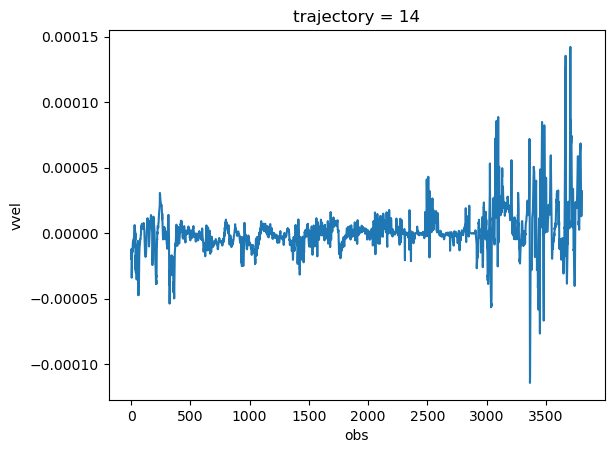

In [18]:
ds_orig_VT.isel(trajectory=2).plot();

In [49]:
ds_Svinoy_overflows = process_section('Svinoy', ds_overflows)['ds_line']
ds_EIC_overflows = process_section('EIC', ds_overflows)['ds_line']
ds_N_overflows = process_section('N', ds_overflows)['ds_line']

In [12]:
ds_Greenland_overflows = process_ocean_basins(ds_overflows)['greenland']
ds_Lofoten_overflows = process_ocean_basins(ds_overflows)['lofoten']
ds_Iceland_overflows = process_ocean_basins(ds_overflows)['iceland']
ds_Norwegian_overflows = process_ocean_basins(ds_overflows)['norwegian']

In [13]:
def filter_trajectories(ds_line,ds_all_trajs):
    """
    Filters trajectories based on whether they cross the line.

    Parameters:
    ds_orig (xarray.Dataset): The original dataset containing trajectory data.
    ds_line (xarray.Dataset): The dataset containing the line information.

    Returns:
    traj_not_line (xarray.Dataset): Trajectories that do not cross the line.
    traj_line (xarray.Dataset): Trajectories that cross the line.
    traj_all (xarray.Dataset): All trajectories from the original dataset.
    """
    # Count the number of NaN values in the 'temp' variable across the 'obs' dimension
    nans_per_traj = (ds_line['temp'].isnull()).sum(dim='obs').compute()
    
    # Select trajectories based on the NaN count
    traj_not_line = ds_all_trajs.sel(trajectory=(nans_per_traj == ds_line.obs.size))  # select all trajs with all nans, i.e. not crossing
    traj_line = ds_all_trajs.sel(trajectory=(nans_per_traj != ds_line.obs.size))  # select all trajs with at least one non-nan, i.e. crossing
    
    # Return all trajectories
    traj_all = ds_all_trajs

    return {
        'traj_line': traj_line,
        'traj_not_line': traj_not_line,
        'traj_all': traj_all
    }


def compute_probability(traj_line_not_all):
    heat_map_obs_non = xhist(traj_line_not_all.lat, traj_line_not_all.lon, bins=[lat_bins, lon_bins], dim=['obs'], bin_dim_suffix="")
    heat_map_obs_unique_non = (heat_map_obs_non > 0).sum(dim='trajectory')
    heat_map_probability_non_cp = heat_map_obs_unique_non.compute()
    return heat_map_probability_non_cp



In [60]:


# def calculate_heatmap(ds):
#     heat_map = xhist(
#         ds.lat, ds.lon, bins=[lat_bins, lon_bins], density=False
#     )
#     heat_map = heat_map.where(heat_map > 0).sum(dim='trajectory')
#     return heat_map



In [39]:
#testing = test_map.isel(obs=9).compute()

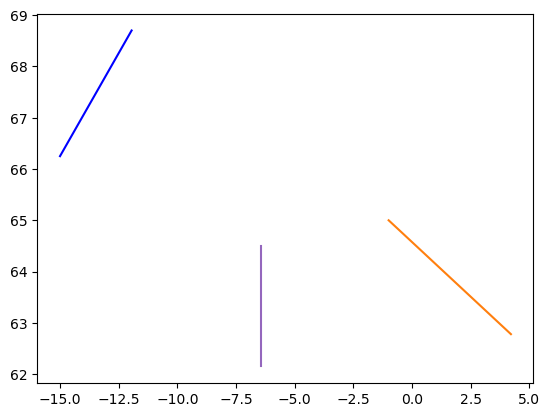

In [52]:
plt.plot([-6.43, -6.43], [62.15, 64.5], color='tab:purple', label='N section')
plt.plot([4.21, -1], [62.78, 65.], color='tab:orange', label='Svinoy section')
plt.plot([-15, -11.95], [66.25, 68.7], color='blue', label='EIC section');

In [96]:
heat_map_all = compute_probability(ds_orig)

In [98]:
Greenland_all = filter_trajectories(ds_Greenland, ds_orig)

In [103]:
Lofoten_all = filter_trajectories(ds_Lofoten, ds_orig)
Iceland_all = filter_trajectories(ds_Iceland, ds_orig)
Norwegian_all = filter_trajectories(ds_Norwegian, ds_orig)

In [99]:
heat_map_greenland = compute_probability(Greenland_all['traj_line'])

In [104]:
heat_map_lofoten = compute_probability(Lofoten_all['traj_line'])
heat_map_iceland = compute_probability(Iceland_all['traj_line'])
heat_map_norwegian = compute_probability(Norwegian_all['traj_line'])

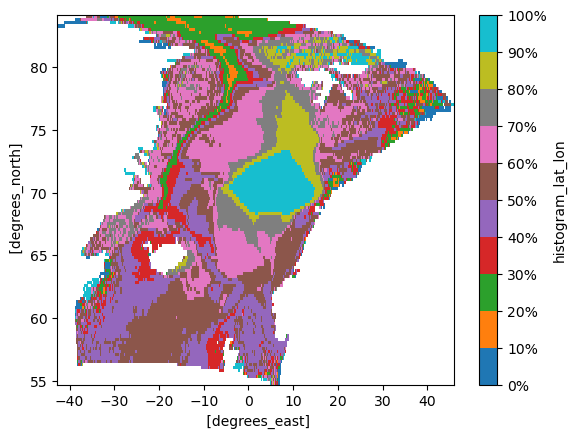

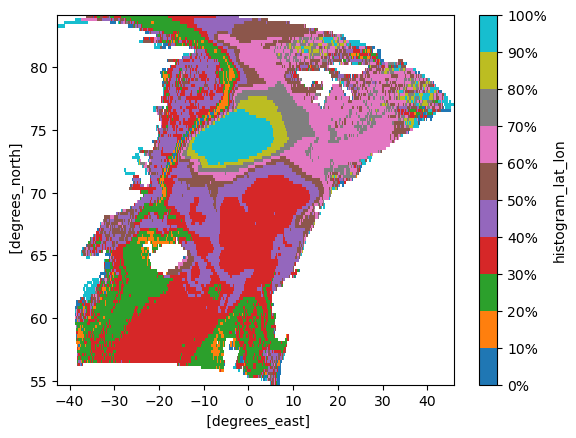

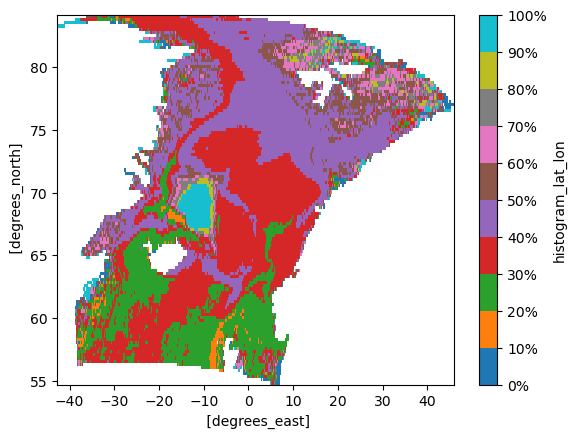

In [ ]:


heatmap = ((heat_map_lofoten/heat_map_all) * 100).plot(cmap='tab10')
#plt.plot([4.21, -1], [62.78, 65.], color='tab:orange', label='Svinoy section')
# Adjust colorbar ticks
cbar = heatmap.colorbar
cbar.set_ticks(np.arange(0, 100 + 10, 10))
cbar.ax.yaxis.set_major_formatter(ticker.PercentFormatter())
plt.show()

heatmap = ((heat_map_greenland/heat_map_all) * 100).plot(cmap='tab10')
#plt.plot([4.21, -1], [62.78, 65.], color='tab:orange', label='Svinoy section')
# Adjust colorbar ticks
cbar = heatmap.colorbar
cbar.set_ticks(np.arange(0, 100 + 10, 10))
cbar.ax.yaxis.set_major_formatter(ticker.PercentFormatter())
plt.show()

heatmap = ((heat_map_iceland/heat_map_all) * 100).plot(cmap='tab10')
#plt.plot([4.21, -1], [62.78, 65.], color='tab:orange', label='Svinoy section')
# Adjust colorbar ticks
cbar = heatmap.colorbar
cbar.set_ticks(np.arange(0, 100 + 10, 10))
cbar.ax.yaxis.set_major_formatter(ticker.PercentFormatter())
plt.show()

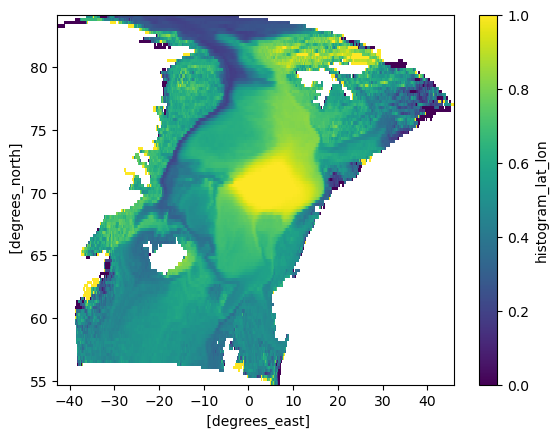

In [106]:
(heat_map_lofoten/heat_map_all).plot()

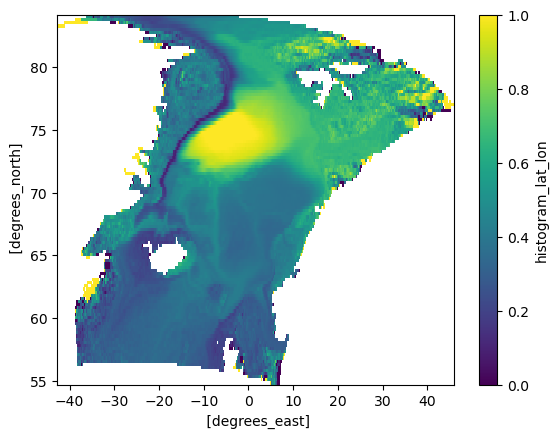

In [102]:
(heat_map_greenland/heat_map_all).plot();

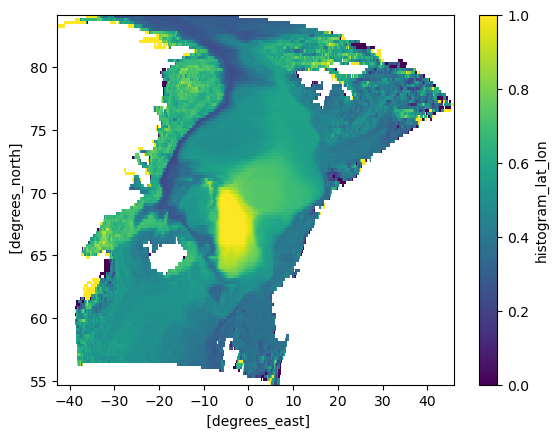

In [111]:
(heat_map_norwegian/heat_map_all).plot();

In [15]:
Svinoy_all = filter_trajectories(ds_Svinoy, ds_orig)
EIC_all = filter_trajectories(ds_EIC, ds_orig)
N_all = filter_trajectories(ds_N, ds_orig)

In [17]:
heat_map_svinoy = compute_probability(Svinoy_all['traj_line'])

In [164]:
heat_map_EIC = compute_probability(EIC_all['traj_line'])
heat_map_N = compute_probability(N_all['traj_line'])

In [47]:
# (heat_map_svinoy/heat_map_all).plot()
# plt.plot([4.21, -1], [62.78, 65.], color='tab:orange', label='Svinoy section');

In [48]:
# (heat_map_N/heat_map_all).plot()
# plt.plot([-6.43, -6.43], [62.15, 64.5], color='tab:purple', label='N section');

In [46]:
# (heat_map_EIC/heat_map_all).plot()
# plt.plot([-15, -11.95], [66.25, 68.7], color='blue', label='EIC section');

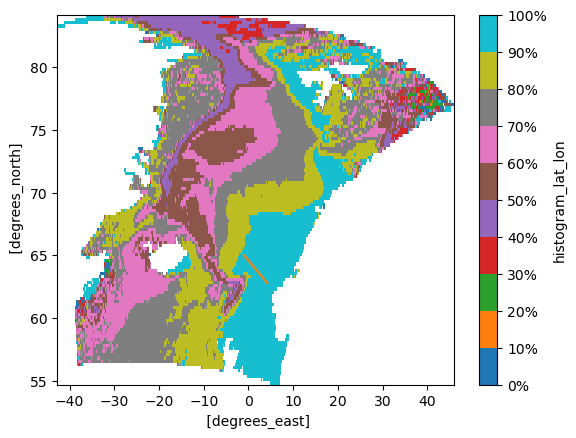

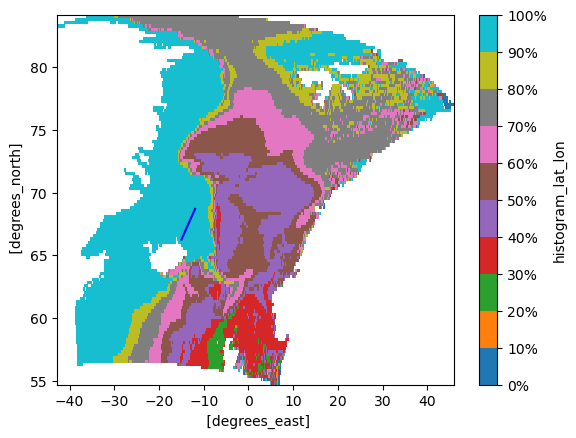

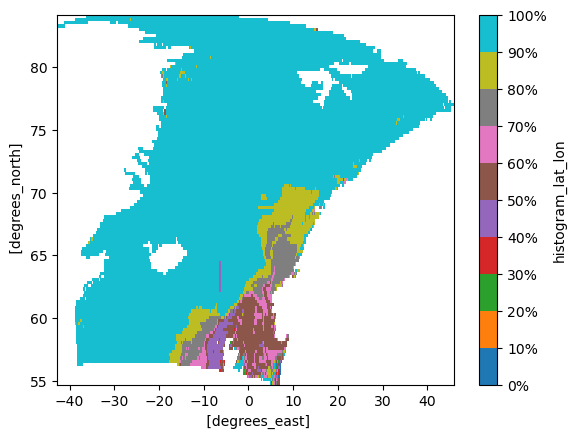

In [24]:
import matplotlib.ticker as ticker

heatmap = ((heat_map_svinoy / heat_map_all) * 100).plot(cmap='tab10')
plt.plot([4.21, -1], [62.78, 65.], color='tab:orange', label='Svinoy section')
# Adjust colorbar ticks
cbar = heatmap.colorbar
cbar.set_ticks(np.arange(0, 100 + 10, 10))
cbar.ax.yaxis.set_major_formatter(ticker.PercentFormatter())
plt.show()

heatmap = ((heat_map_EIC / heat_map_all) * 100).plot(cmap='tab10')
plt.plot([-15, -11.95], [66.25, 68.7], color='blue', label='EIC section')
# Adjust colorbar ticks
cbar = heatmap.colorbar
cbar.set_ticks(np.arange(0, 100 + 10, 10))
cbar.ax.yaxis.set_major_formatter(ticker.PercentFormatter())
plt.show()

heatmap = ((heat_map_N / heat_map_all) * 100).plot(cmap='tab10')
plt.plot([-6.43, -6.43], [62.15, 64.5], color='tab:purple', label='N section')
cbar = heatmap.colorbar
cbar.set_ticks(np.arange(0, 100 + 10, 10))
cbar.ax.yaxis.set_major_formatter(ticker.PercentFormatter())
plt.show()

In [29]:
# nans_none = (ds_N_line['temp'].isnull() & ds_Svinoy_line['temp'].isnull()).sum(dim='obs')
# traj_not = ds_orig.sel(trajectory=(nans_none == 20075))

# heat_map_obs_non = xhist(traj_not.lat, traj_not.lon, bins=[lat_bins, lon_bins], dim=['obs'], bin_dim_suffix="")

# heat_map_obs_unique_non = (heat_map_obs_non > 0).sum(dim='trajectory')

# heat_map_probability_non_cp = heat_map_obs_unique_non.compute()


In [15]:
heat_map_overflows = compute_probability(ds_overflows)

In [16]:
Lofoten_overflows = filter_trajectories(ds_Lofoten_overflows, ds_overflows)


In [17]:
Iceland_overflows = filter_trajectories(ds_Iceland_overflows, ds_overflows)
Greenland_overflows = filter_trajectories(ds_Greenland_overflows, ds_overflows)
Norwegian_overflows = filter_trajectories(ds_Norwegian_overflows, ds_overflows)

In [122]:
Lofoten_overflows['traj_line'].trajectory.size

57947

In [127]:
print(Greenland_overflows['traj_line'].trajectory.size, Iceland_overflows['traj_line'].trajectory.size, 
      Lofoten_overflows['traj_line'].trajectory.size, Norwegian_overflows['traj_line'].trajectory.size)

62650 58188 57947 63942


In [134]:
np.array([Greenland_overflows['traj_line'].trajectory.size, Iceland_overflows['traj_line'].trajectory.size, 
      Lofoten_overflows['traj_line'].trajectory.size, Norwegian_overflows['traj_line'].trajectory.size]).sum()

242727

In [126]:
print(Greenland_all['traj_line'].trajectory.size, Iceland_all['traj_line'].trajectory.size, 
      Lofoten_all['traj_line'].trajectory.size, Norwegian_all['traj_line'].trajectory.size)

187820 178341 221659 217172


In [130]:
np.array([Greenland_all['traj_line'].trajectory.size, Iceland_all['traj_line'].trajectory.size,
       Lofoten_all['traj_line'].trajectory.size, Norwegian_all['traj_line'].trajectory.size]).sum()

804992

In [19]:
Svinoy_overflows = filter_trajectories(ds_Svinoy_overflows, ds_overflows)

In [20]:

EIC_overflows = filter_trajectories(ds_EIC_overflows, ds_overflows)
N_overflows = filter_trajectories(ds_N_overflows, ds_overflows)



In [18]:
def rechunk_lat_lon(ds):
    """
    Rechunk latitude and longitude data from the given xarray dataset.

    Parameters:
    ds (xarray.Dataset): The input dataset containing 'lon' and 'lat' variables.

    Returns:
    tuple: A tuple containing the rechunked longitude and latitude arrays.
    """
    lon_rechunk = rechunk_for_hist(ds['lon'])
    lat_rechunk = rechunk_for_hist(ds['lat'])
    
    return lon_rechunk, lat_rechunk

#lon_rechunk, lat_rechunk = rechunk_lat_lon(ds_overflows)[0], rechunk_lat_lon(ds_overflows)[1]
def get_mean_maps(ds,lon_rechunk,lat_rechunk):
    weights = xr.ones_like(ds)
    weighted_sum = xhist(lon_rechunk, lat_rechunk, bins=[lon_bins, lat_bins], weights=ds, dim=["obs", "trajectory"])
    counts = xhist(lon_rechunk, lat_rechunk, bins=[lon_bins, lat_bins], weights=weights, dim=["obs", "trajectory"])
    mean_temp = weighted_sum / counts
    return mean_temp



In [19]:
heat_map_greenland_overflows = compute_probability(Greenland_overflows['traj_line'])

In [22]:

heat_map_lofoten_overflows = compute_probability(Lofoten_overflows['traj_line'])
heat_map_iceland_overflows = compute_probability(Iceland_overflows['traj_line'])
heat_map_norwegian_overflows = compute_probability(Norwegian_overflows['traj_line'])

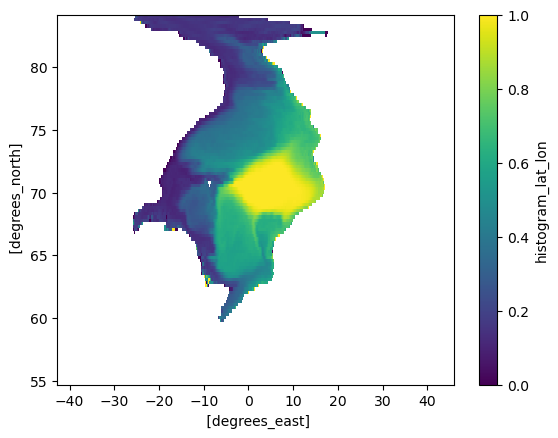

In [142]:
(heat_map_lofoten_overflows/heat_map_overflows).plot()

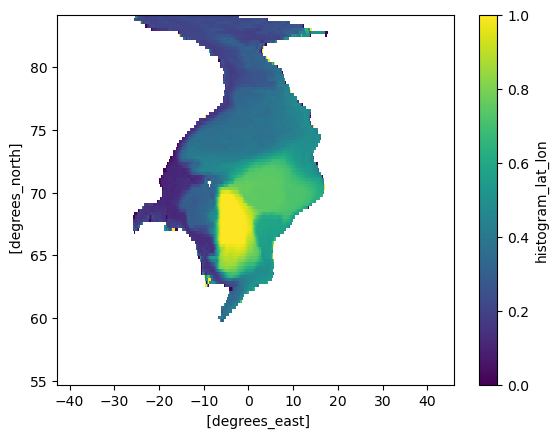

In [23]:
(heat_map_norwegian_overflows/heat_map_overflows).plot();

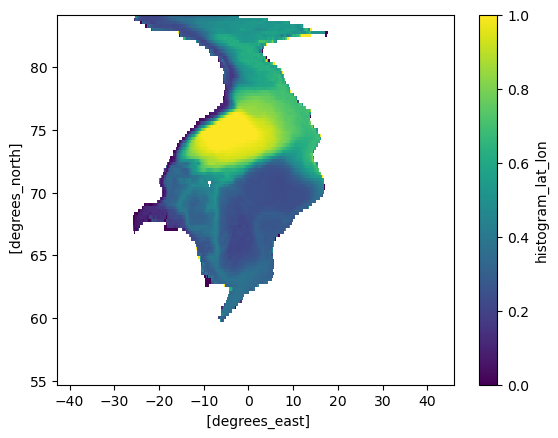

In [20]:
(heat_map_greenland_overflows/heat_map_overflows).plot();

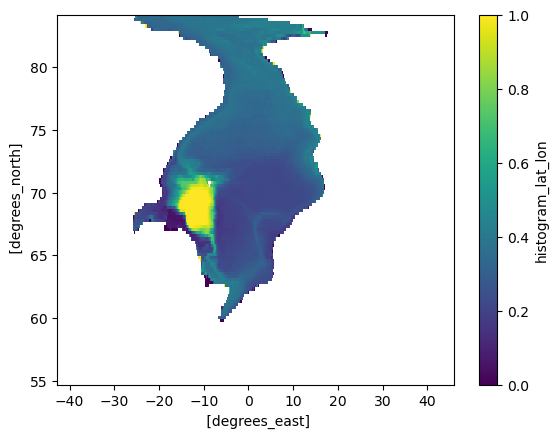

In [24]:
(heat_map_iceland_overflows/heat_map_overflows).plot()

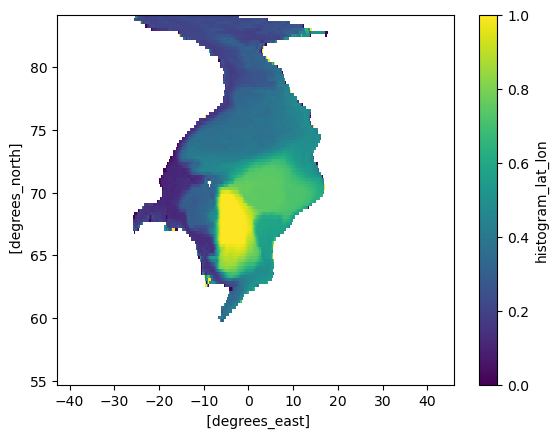

In [145]:
(heat_map_norwegian_overflows/heat_map_overflows).plot()

In [139]:
# converting the age from nano seconds 

hours_to_days=0.0416667
hours_to_months=0.00136986
hours_to_years=0.000114155
time_conversion = hours_to_days
velocity_conversion = 1852 * 60 #multiply the value of the V field with 1852 * 60 (the number of meters in 1 degree of latitude)

In [23]:
Svinoy_mean_age_overflows = get_mean_maps(Svinoy_overflows['traj_line'].age,
                                          rechunk_lat_lon(Svinoy_overflows['traj_line'])[0],
                                          rechunk_lat_lon(Svinoy_overflows['traj_line'])[1]).compute()

In [24]:
EIC_mean_age_overflows = get_mean_maps(EIC_overflows['traj_line'].age,
                                       rechunk_lat_lon(EIC_overflows['traj_line'])[0],
                                       rechunk_lat_lon(EIC_overflows['traj_line'])[1]).compute()

N_mean_age_overflows = get_mean_maps(N_overflows['traj_line'].age,
                                     rechunk_lat_lon(N_overflows['traj_line'])[0],
                                     rechunk_lat_lon(N_overflows['traj_line'])[1]).compute()

In [25]:
land_mask_ones = mesh_mask.tmask.isel(t=0,z=0)

In [33]:
Svinoy_mean_temp_overflows = get_mean_maps(Svinoy_overflows['traj_line'].temp,
                                          rechunk_lat_lon(Svinoy_overflows['traj_line'])[0],
                                          rechunk_lat_lon(Svinoy_overflows['traj_line'])[1]).compute()

In [209]:
# basin mean ages

Greenland_mean_age_overflows = get_mean_maps(Greenland_overflows['traj_line'].age,
                                          rechunk_lat_lon(Greenland_overflows['traj_line'])[0],
                                          rechunk_lat_lon(Greenland_overflows['traj_line'])[1]).compute()

Lofoten_mean_age_overflows = get_mean_maps(Lofoten_overflows['traj_line'].age,
                                          rechunk_lat_lon(Lofoten_overflows['traj_line'])[0],
                                          rechunk_lat_lon(Lofoten_overflows['traj_line'])[1]).compute()



In [211]:
Iceland_mean_age_overflows = get_mean_maps(Iceland_overflows['traj_line'].age,
                                          rechunk_lat_lon(Iceland_overflows['traj_line'])[0],
                                          rechunk_lat_lon(Iceland_overflows['traj_line'])[1]).compute()
Norwegian_mean_age_overflows = get_mean_maps(Norwegian_overflows['traj_line'].age,
                                          rechunk_lat_lon(Norwegian_overflows['traj_line'])[0],
                                          rechunk_lat_lon(Norwegian_overflows['traj_line'])[1]).compute()

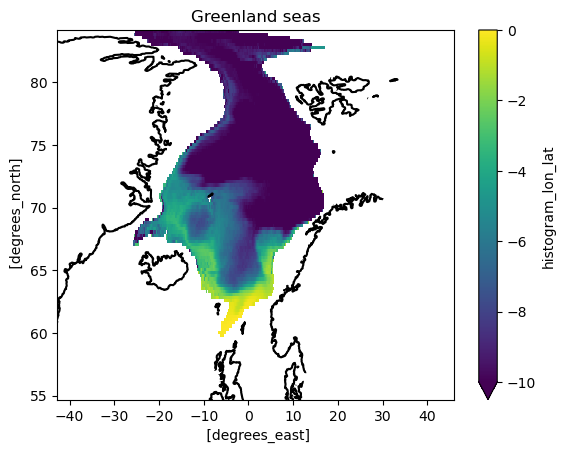

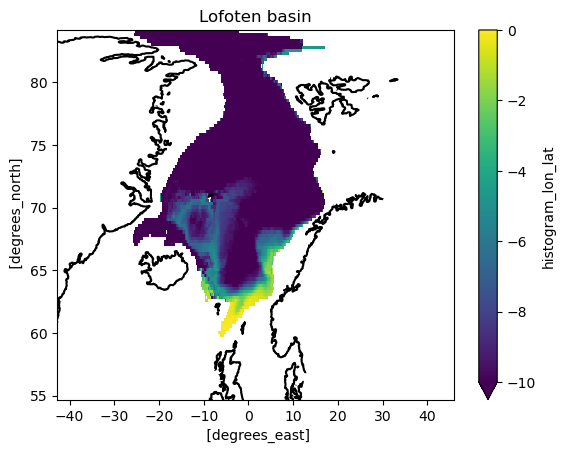

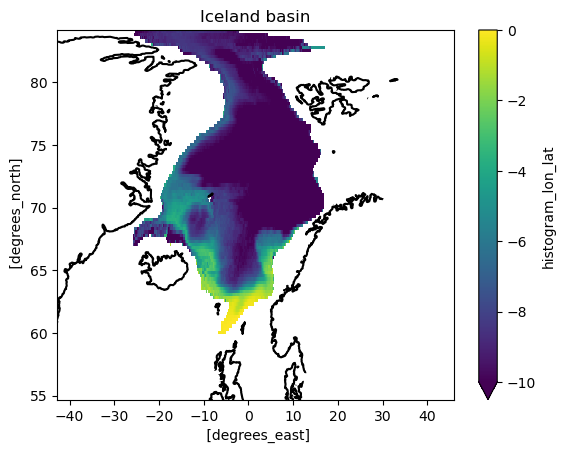

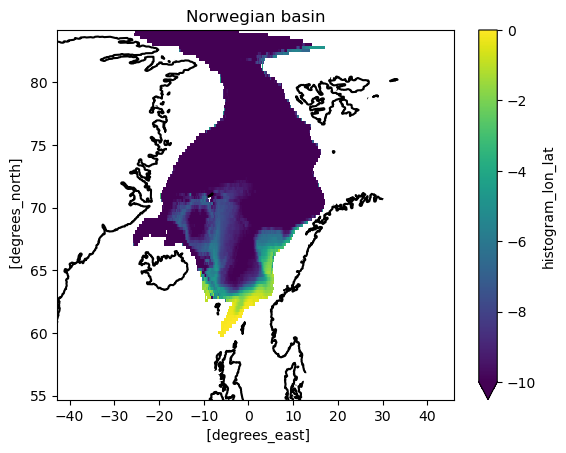

In [212]:

plt.contour(mesh_mask.nav_lon, mesh_mask.nav_lat, mesh_mask.tmask.isel(t=0,z=0),levels=0,colors='k')
heatmap = (Greenland_mean_age_overflows.T*hours_to_years).plot(cmap='viridis', vmin=-10,vmax=0)
plt.title('Greenland seas')
cbar = heatmap.colorbar
#cbar.set_ticks(np.arange(0, 100 + 10, 10))
#cbar.ax.yaxis.set_major_formatter(ticker.PercentFormatter())
plt.show()

plt.contour(mesh_mask.nav_lon, mesh_mask.nav_lat, mesh_mask.tmask.isel(t=0,z=0),levels=0,colors='k')
heatmap = (Lofoten_mean_age_overflows.T*hours_to_years).plot(cmap='viridis', vmin=-10,vmax=0)
plt.title('Lofoten basin')
cbar = heatmap.colorbar
#cbar.set_ticks(np.arange(0, 100 + 10, 10))
#cbar.ax.yaxis.set_major_formatter(ticker.PercentFormatter())
plt.show()

plt.contour(mesh_mask.nav_lon, mesh_mask.nav_lat, mesh_mask.tmask.isel(t=0,z=0),levels=0,colors='k')
heatmap = (Iceland_mean_age_overflows.T*hours_to_years).plot(cmap='viridis', vmin=-10,vmax=0)
plt.title('Iceland basin')
cbar = heatmap.colorbar
#cbar.set_ticks(np.arange(0, 100 + 10, 10))
#cbar.ax.yaxis.set_major_formatter(ticker.PercentFormatter())
plt.show()

plt.contour(mesh_mask.nav_lon, mesh_mask.nav_lat, mesh_mask.tmask.isel(t=0,z=0),levels=0,colors='k')
heatmap = (Norwegian_mean_age_overflows.T*hours_to_years).plot(cmap='viridis', vmin=-10,vmax=0)
plt.title('Norwegian basin')
cbar = heatmap.colorbar
#cbar.set_ticks(np.arange(0, 100 + 10, 10))
#cbar.ax.yaxis.set_major_formatter(ticker.PercentFormatter())
plt.show()

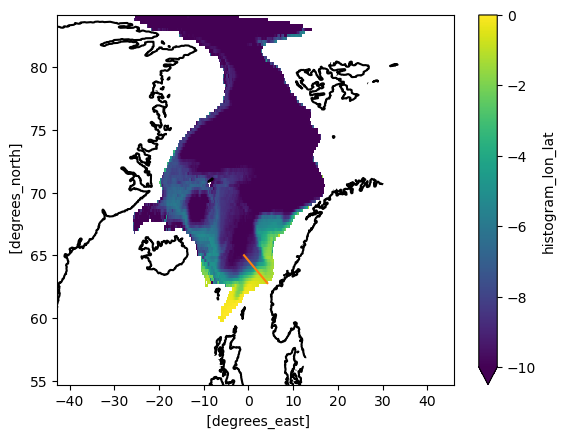

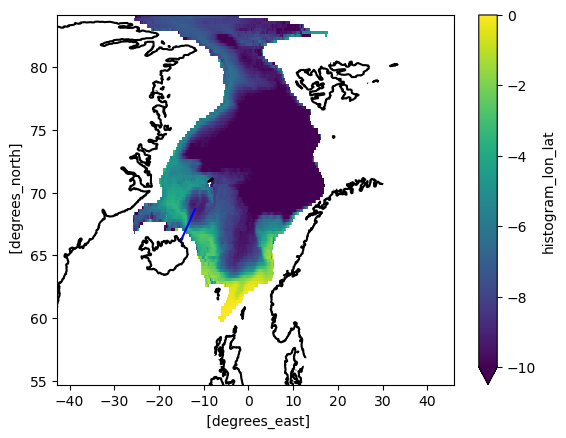

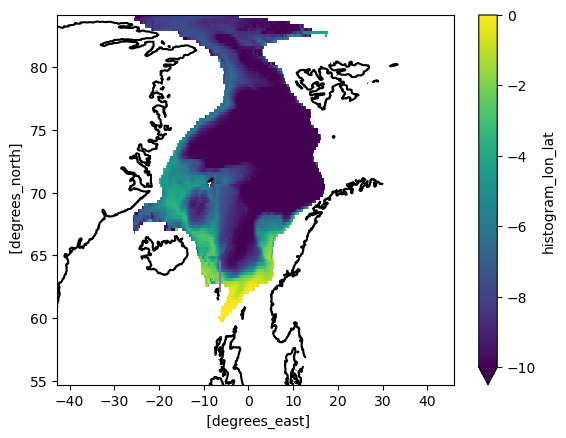

In [72]:

plt.contour(mesh_mask.nav_lon, mesh_mask.nav_lat, mesh_mask.tmask.isel(t=0,z=0),levels=0,colors='k')
heatmap = (Svinoy_mean_age_overflows.T*hours_to_years).plot(cmap='viridis', vmin=-10,vmax=0)
plt.plot([4.21, -1], [62.78, 65.], color='tab:orange', label='Svinoy section')
cbar = heatmap.colorbar
#cbar.set_ticks(np.arange(0, 100 + 10, 10))
#cbar.ax.yaxis.set_major_formatter(ticker.PercentFormatter())
plt.show()

plt.contour(mesh_mask.nav_lon, mesh_mask.nav_lat, mesh_mask.tmask.isel(t=0,z=0),levels=0,colors='k')
heatmap = (EIC_mean_age_overflows.T*hours_to_years).plot(cmap='viridis', vmin=-10,vmax=0)
plt.plot([-15, -11.95], [66.25, 68.7], color='blue', label='EIC section')
cbar = heatmap.colorbar
#cbar.set_ticks(np.arange(0, 100 + 10, 10))
#cbar.ax.yaxis.set_major_formatter(ticker.PercentFormatter())
plt.show()

plt.contour(mesh_mask.nav_lon, mesh_mask.nav_lat, mesh_mask.tmask.isel(t=0,z=0),levels=0,colors='k')
heatmap = (N_mean_age_overflows.T*hours_to_years).plot(cmap='viridis', vmin=-10,vmax=0)
plt.plot([-6.43, -6.43], [62.15, 64.5], color='tab:purple', label='N section')
cbar = heatmap.colorbar
plt.show()


In [25]:
def compute_heat_maps(ds):
    """
    Compute heat maps and probabilities from the given dataset.

    Parameters:
    ds (xarray.Dataset): The input dataset containing latitude, longitude, and trajectory data.
    lat_bins (array-like): The bins for latitude.
    lon_bins (array-like): The bins for longitude.

    Returns:
    dict: A dictionary containing the computed heat maps and probabilities.
    """
    
    # Compute heat map of observations
    heat_map_obs = xhist(ds.lat, ds.lon, bins=[lat_bins, lon_bins], dim=['obs'], bin_dim_suffix="")
    
    # Compute heat map of trajectories
    heat_map_traj = xhist(ds.lat, ds.lon, bins=[lat_bins, lon_bins], bin_dim_suffix="")
    
    # Summing particle counts over the whole integration period
    heat_map_obs_sum = heat_map_traj
    
    # Dividing by the total number of particle counts for all bins
    total_counts = heat_map_obs_sum.sum() # number of valid data points 
    heat_map_normalized = heat_map_obs_sum / total_counts

    # Calculate the total number of observations
    total_observations = ds.obs.size

    # Calculate the probability for each bin
    heat_map_probability_obs = (heat_map_obs / total_observations) * 100

    # Summing particle counts over the whole integration period, considering each particle only once per bin
    heat_map_obs_unique = (heat_map_obs > 0).sum(dim='trajectory')

    # Dividing by the total number of particles to get the probability for each bin
    total_particles = ds.trajectory.size
    heat_map_probability = (heat_map_obs_unique / total_particles) * 100

    # Compute the results
    heat_map_normalized_comp = heat_map_normalized#.compute()
    heat_map_compute = heat_map_obs.sum(dim='trajectory')#.compute()
    heat_map_probability_compute = heat_map_probability.compute()

    return {
        'heat_map_normalized': heat_map_normalized_comp.compute(),
        'heat_map_compute': heat_map_compute,
        'heat_map_probability': heat_map_probability_compute,
        'heat_map_probability_obs': heat_map_probability_obs
    }



In [241]:
#xhist(Svinoy_overflows['traj_line'].lat, Svinoy_overflows['traj_line'].lon, bins=[lat_bins, lon_bins], bin_dim_suffix="")

In [26]:
def get_heat_maps_per_count(ds):
       # Compute heat map of observations
    # Summing particle counts over the whole integration period
   heat_map_traj = xhist(ds.lat, ds.lon, bins=[lat_bins, lon_bins], dim=['obs'], bin_dim_suffix="")
   heat_map_obs_sum = heat_map_traj.sum(dim='trajectory')  # This is already the sum of unique counts per bin

   # Dividing by the total number of unique particles for normalization
   total_counts = ds.trajectory.size
   heat_map_normalized = heat_map_obs_sum
   return heat_map_normalized.compute()


In [229]:
#xhist(Svinoy_overflows['traj_line'].lat, Svinoy_overflows['traj_line'].lon, bins=[lat_bins, lon_bins], dim=['obs'], bin_dim_suffix="").sum(dim='trajectory').compute()

In [234]:
Svinoy_overflows_hm = get_heat_maps_per_count(Svinoy_overflows['traj_line'])

In [9]:
ds = ds_overflows #Svinoy_overflows['traj_line']

In [11]:
ds['lat_discrete'] = np.round(ds.lat, 1)
ds['lon_discrete'] = np.round(ds.lon, 1)

In [49]:
# test = np.zeros((len(lat_bins)-1, len(lon_bins)-1))
# for i, traj in enumerate(ds.trajectory):
#     print(i, end='')
#     ds_traj = ds.sel(trajectory=traj)
#     h = xhist(ds_traj.lat, ds_traj.lon, bins=[lat_bins, lon_bins], bin_dim_suffix="")
#     test += (h > 0).astype(float)  # if prob was larger 0 for a parcel of this traj to be in the lat/lon box, set it to 1 otherwise to 0
#     if i > 10000: break
# test_probs = test / ds.trajectory.size * 100

In [12]:
counts = np.zeros((len(lat_bins)-1, len(lon_bins)-1))
for i, traj in enumerate(ds.trajectory):
    print(i, end='')
    ds_traj = ds.sel(trajectory=traj)
    h=xhist(ds_traj.lat_discrete, ds_traj.lon_discrete, bins=[lat_bins, lon_bins], bin_dim_suffix="")
    counts += (h>0).astype(float) # if prob was larger 0 for a parcel of this traj to be in the lat/lon box, set it to 1 otherwise to 0
    # if i > 10000: break
probs = counts / ds.trajectory.size * 100

0123456789101112131415161718192021222324252627282930313233343536373839404142434445464748495051525354555657585960616263646566676869707172737475767778798081828384858687888990919293949596979899100101102103104105106107108109110111112113114115116117118119120121122123124125126127128129130131132133134135136137138139140141142143144145146147148149150151152153154155156157158159160161162163164165166167168169170171172173174175176177178179180181182183184185186187188189190191192193194195196197198199200201202203204205206207208209210211212213214215216217218219220221222223224225226227228229230231232233234235236237238239240241242243244245246247248249250251252253254255256257258259260261262263264265266267268269270271272273274275276277278279280281282283284285286287288289290291292293294295296297298299300301302303304305306307308309310311312313314315316317318319320321322323324325326327328329330331332333334335336337338339340341342343344345346347348349350351352353354355356357358359360361362363364365366367368369

In [13]:
probs = probs.compute()

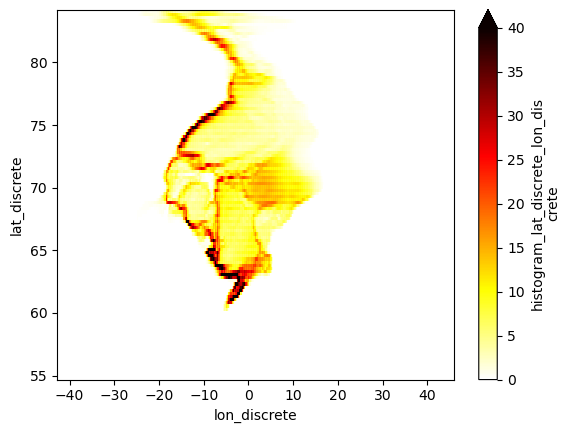

In [17]:
probs.plot(cmap='hot_r', vmin=0, vmax=40);

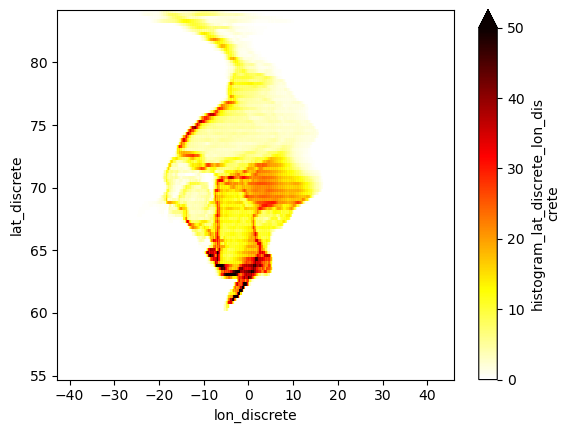

In [39]:
probs.plot(cmap='hot_r', vmin=0, vmax=50);

In [256]:
h=xhist(ds.lat_discrete, ds.lon_discrete, bins=[np.arange(55,90,0.1), np.arange(-40,40,0.1)], bin_dim_suffix="")

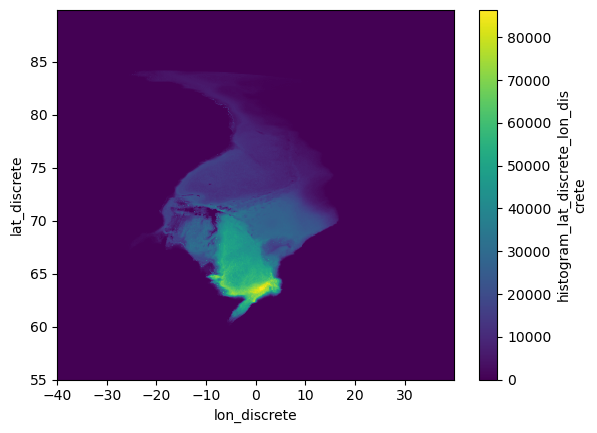

In [257]:
h.plot()

In [247]:
xhist(ds.lat, ds.lon, bins=[lat_bins, lon_bins], bin_dim_suffix="")#.isel(trajectory=0).plot();

<xarray.DataArray 'histogram_lat_lon' (lat: 118, lon: 355)>
dask.array<sum-aggregate, shape=(118, 355), dtype=int64, chunksize=(118, 355), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 54.8 55.05 55.3 55.55 55.8 ... 83.3 83.55 83.8 84.05
  * lon      (lon) float64 -42.67 -42.42 -42.17 -41.92 ... 45.33 45.58 45.83

In [ ]:
#,vmin=0,vmax=10**2

In [202]:
EIC_overflows_hm = get_heat_maps_per_count(EIC_overflows['traj_line'])


In [205]:
N_overflows_hm = get_heat_maps_per_count(N_overflows['traj_line'])

In [ ]:
Svinoy_overflows_hm

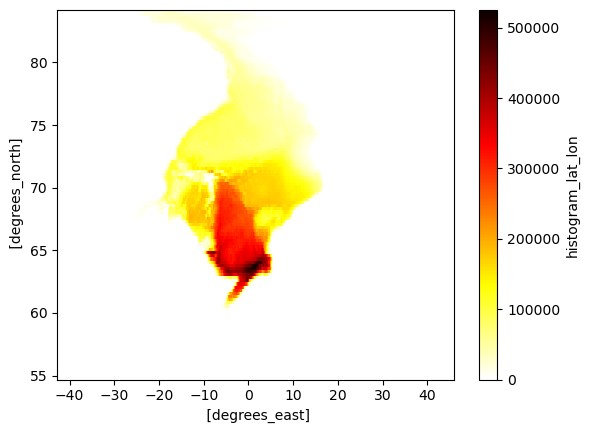

In [244]:
x = Svinoy_overflows_hm

(Svinoy_overflows_hm.plot(cmap='hot_r')

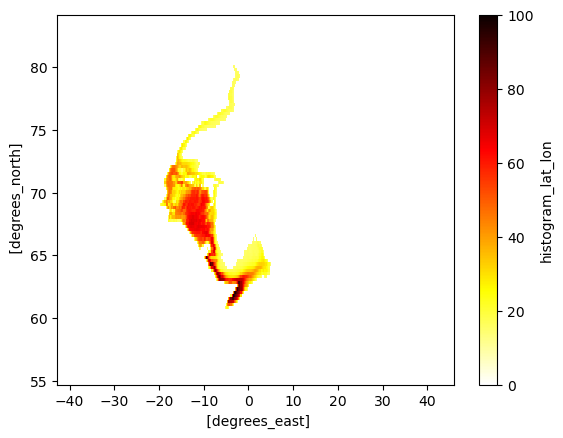

In [222]:
x = EIC_overflows_hm*15

x.where(x > 15).plot(cmap='hot_r',vmin=0,vmax=10**2)

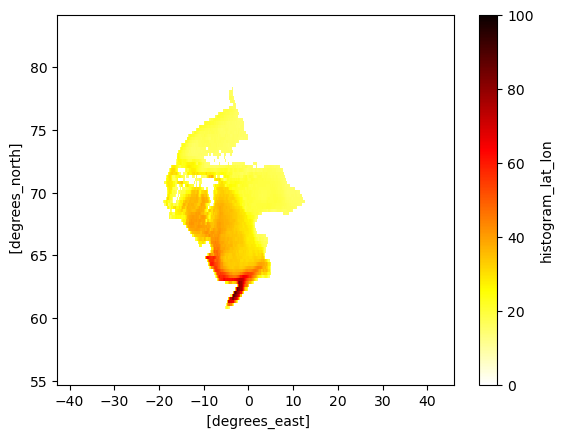

In [224]:
x = N_overflows_hm*15

x.where(x > 15).plot(cmap='hot_r',vmin=0,vmax=10**2)

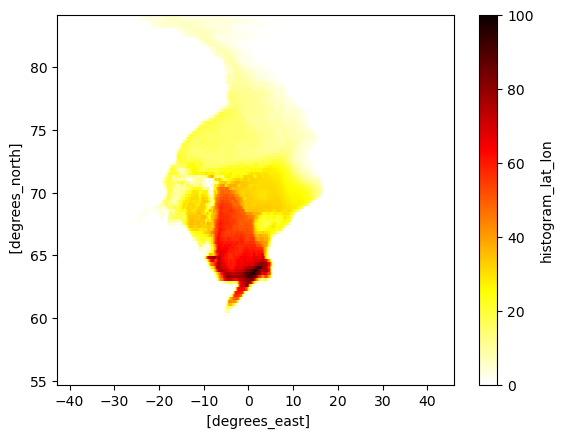

In [214]:
(Svinoy_overflows_hm*15).plot(cmap='hot_r',vmin=0,vmax=10**2)

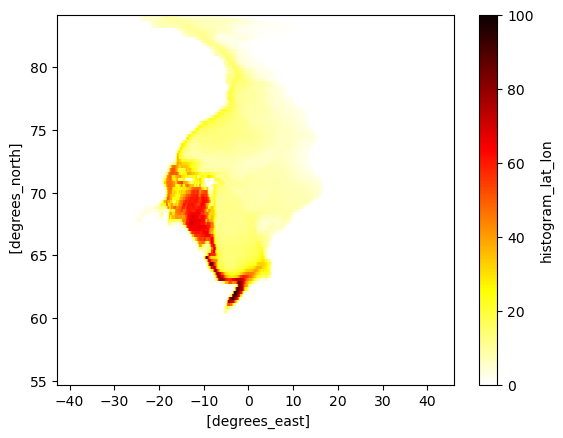

In [215]:
(EIC_overflows_hm*15).plot(cmap='hot_r',vmin=0,vmax=10**2)

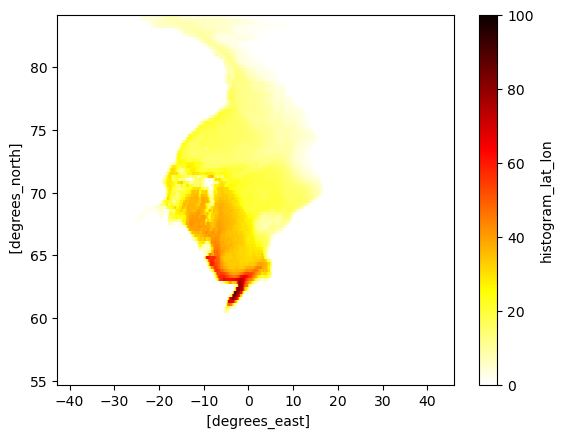

In [216]:
(N_overflows_hm*15).plot(cmap='hot_r',vmin=0,vmax=10**2)

In [36]:

print('percent of trajectories from deeper flows = ', 
      (N_overflows['traj_line'].trajectory.size+EIC_overflows['traj_line'].trajectory.size+Svinoy_overflows['traj_line'].trajectory.size)/ds_orig.trajectory.size*100,
      '%')

percent of trajectories from deeper flows =  71.8645323134411 %


In [37]:
EIC_overflows['traj_not_line'].trajectory.size + EIC_overflows['traj_line'].trajectory.size

168397

In [38]:
Svinoy_overflows['traj_not_line'].trajectory.size #+ EIC_overflows['traj_line'].trajectory.size

87086

In [39]:
Svinoy_overflows['traj_line'].trajectory.size

81311

In [40]:
EIC_overflows['traj_line'].trajectory.size

98776

In [41]:
N_overflows['traj_line'].trajectory.size

163396

100%|██████████| 17/17 [00:10<00:00,  1.61it/s]


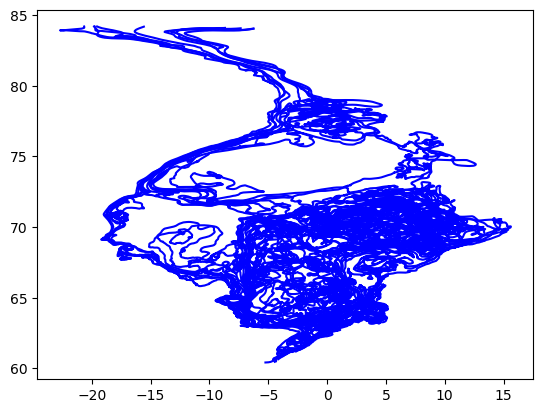

In [115]:
import tqdm
for i in tqdm.tqdm(np.arange(0, len(Svinoy_overflows['traj_line'].trajectory), 5_000)):
    plt.plot(Svinoy_overflows['traj_line'].lon.isel(trajectory=i), Svinoy_overflows['traj_line'].lat.isel(trajectory=i), color='blue')
    #plt.plot(EIC_overflows['traj_line'].lon.isel(trajectory=i), EIC_overflows['traj_line'].lat.isel(trajectory=i), color='red')
    #plt.plot(N_overflows['traj_line'].lon.isel(trajectory=i), N_overflows['traj_line'].lat.isel(trajectory=i), color='green')
plt.show()

100%|██████████| 17/17 [00:11<00:00,  1.47it/s]


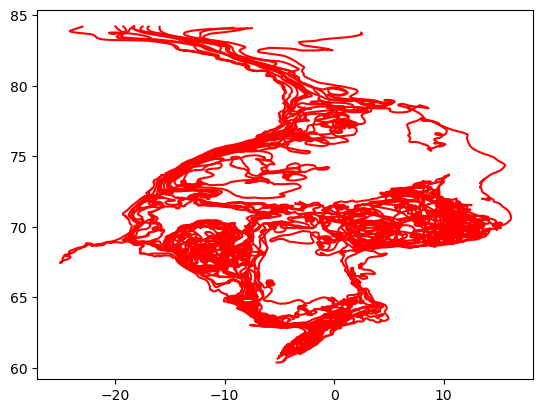

In [116]:

for i in tqdm.tqdm(np.arange(0, len(Svinoy_overflows['traj_line'].trajectory), 5_000)):
    #plt.plot(Svinoy_overflows['traj_line'].lon.isel(trajectory=i), Svinoy_overflows['traj_line'].lat.isel(trajectory=i), color='blue')
    plt.plot(EIC_overflows['traj_line'].lon.isel(trajectory=i), EIC_overflows['traj_line'].lat.isel(trajectory=i), color='red')
    #plt.plot(N_overflows['traj_line'].lon.isel(trajectory=i), N_overflows['traj_line'].lat.isel(trajectory=i), color='green')
plt.show()

100%|██████████| 17/17 [00:10<00:00,  1.68it/s]


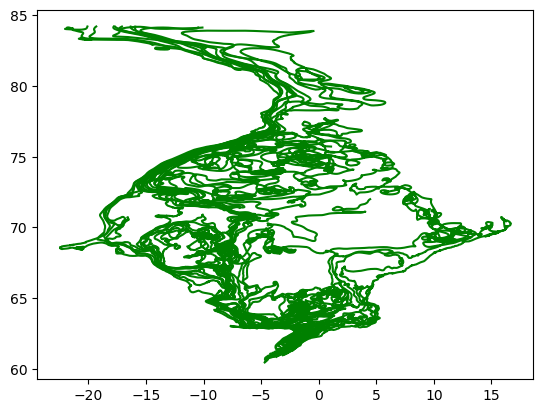

In [117]:

for i in tqdm.tqdm(np.arange(0, len(Svinoy_overflows['traj_line'].trajectory), 5_000)):
    #plt.plot(Svinoy_overflows['traj_line'].lon.isel(trajectory=i), Svinoy_overflows['traj_line'].lat.isel(trajectory=i), color='blue')
    #plt.plot(EIC_overflows['traj_line'].lon.isel(trajectory=i), EIC_overflows['traj_line'].lat.isel(trajectory=i), color='red')
    plt.plot(N_overflows['traj_line'].lon.isel(trajectory=i), N_overflows['traj_line'].lat.isel(trajectory=i), color='green')
plt.show()

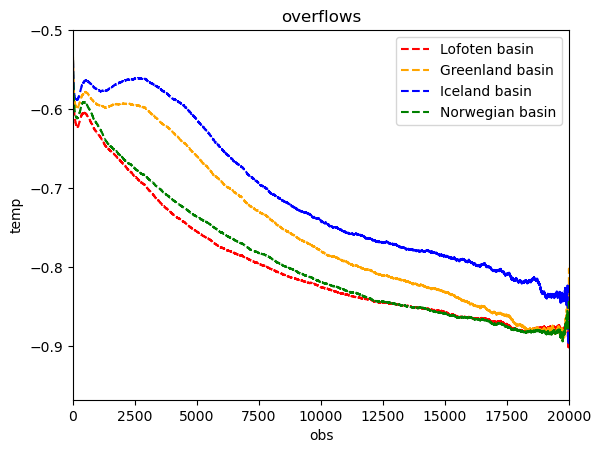

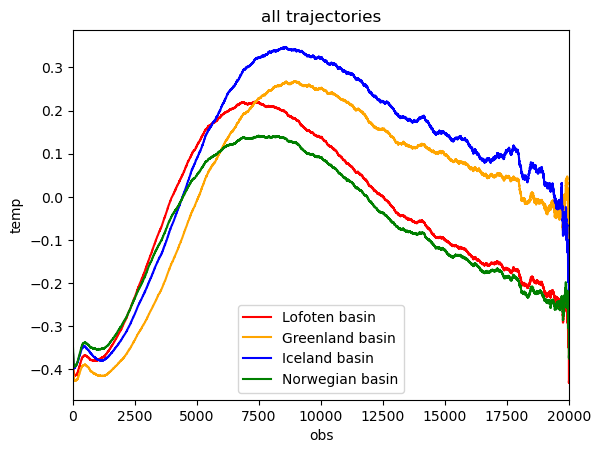

In [204]:
Lofoten_overflows['traj_line'].mean(dim='trajectory').temp.plot(color='red',linestyle='dashed', label='Lofoten basin')
Greenland_overflows['traj_line'].mean(dim='trajectory').temp.plot(color='orange',linestyle='dashed', label='Greenland basin')
Iceland_overflows['traj_line'].mean(dim='trajectory').temp.plot(color='blue',linestyle='dashed', label='Iceland basin')
Norwegian_overflows['traj_line'].mean(dim='trajectory').temp.plot(color='green', linestyle='dashed', label='Norwegian basin')
plt.xlim(0,20_000)
plt.title('overflows')
plt.legend()
plt.ylim(None,-.5)
plt.show()

Lofoten_all['traj_line'].mean(dim='trajectory').temp.plot(color='red',linestyle='solid', label='Lofoten basin')
Greenland_all['traj_line'].mean(dim='trajectory').temp.plot(color='orange',linestyle='solid', label='Greenland basin')
Iceland_all['traj_line'].mean(dim='trajectory').temp.plot(color='blue',linestyle='solid', label='Iceland basin')
Norwegian_all['traj_line'].mean(dim='trajectory').temp.plot(color='green', linestyle='solid', label='Norwegian basin')
plt.xlim(0,20_000)
plt.title('all trajectories')
plt.legend()
plt.show()


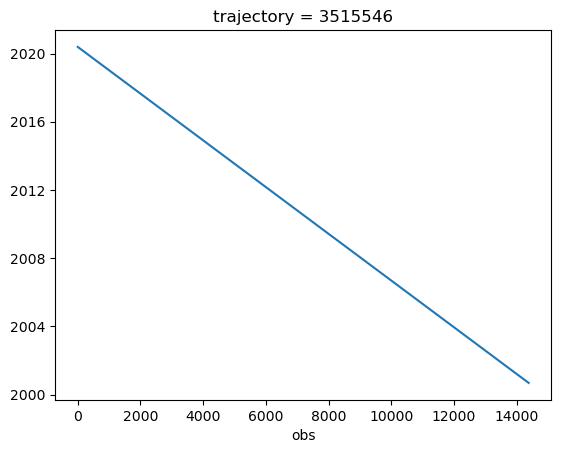

In [207]:
Greenland_overflows['traj_line'].isel(trajectory=-100).time.plot();

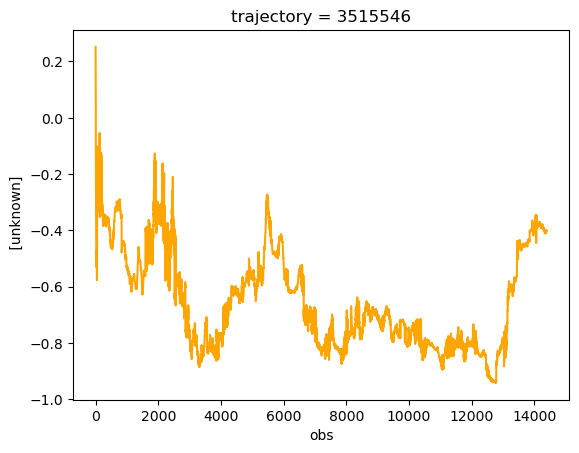

In [206]:
Greenland_overflows['traj_line'].isel(trajectory=-100).temp.plot(color='orange',linestyle='solid', label='Greenland basin')

100%|██████████| 13/13 [00:04<00:00,  3.24it/s]


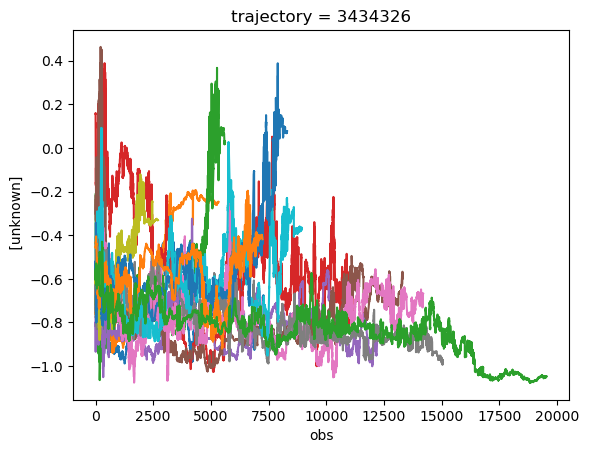

In [178]:
for i in tqdm.tqdm(np.arange(0, len(Greenland_overflows['traj_line'].trajectory), 5_000)):
    Greenland_overflows['traj_line'].isel(trajectory=i).temp.plot()

plt.show()

100%|██████████| 13/13 [00:09<00:00,  1.43it/s]


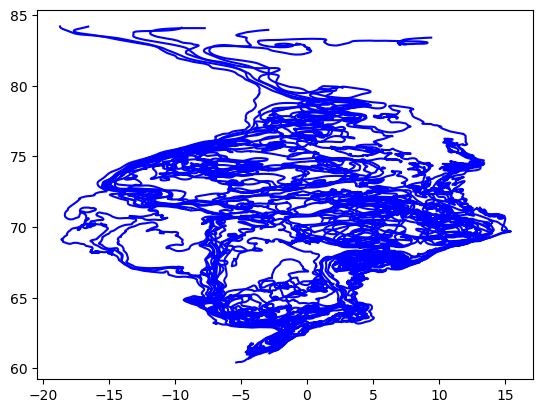

In [167]:
import tqdm
for i in tqdm.tqdm(np.arange(0, len(Greenland_overflows['traj_line'].trajectory), 5_000)):
    plt.plot(Greenland_overflows['traj_line'].lon.isel(trajectory=i), Greenland_overflows['traj_line'].lat.isel(trajectory=i), color='blue')
    #plt.plot(EIC_overflows['traj_line'].lon.isel(trajectory=i), EIC_overflows['traj_line'].lat.isel(trajectory=i), color='red')
    #plt.plot(N_overflows['traj_line'].lon.isel(trajectory=i), N_overflows['traj_line'].lat.isel(trajectory=i), color='green')
plt.show()

100%|██████████| 12/12 [00:05<00:00,  2.14it/s]


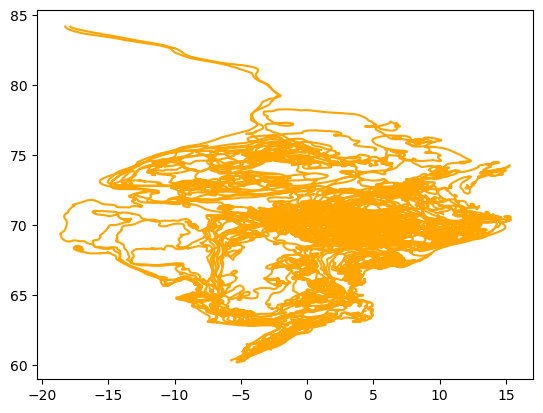

In [169]:
for i in tqdm.tqdm(np.arange(0, len(Lofoten_overflows['traj_line'].trajectory), 5_000)):
    plt.plot(Lofoten_overflows['traj_line'].lon.isel(trajectory=i), Lofoten_overflows['traj_line'].lat.isel(trajectory=i), color='orange')
    #plt.plot(EIC_overflows['traj_line'].lon.isel(trajectory=i), EIC_overflows['traj_line'].lat.isel(trajectory=i), color='red')
    #plt.plot(N_overflows['traj_line'].lon.isel(trajectory=i), N_overflows['traj_line'].lat.isel(trajectory=i), color='green')
plt.show()

100%|██████████| 12/12 [00:08<00:00,  1.43it/s]


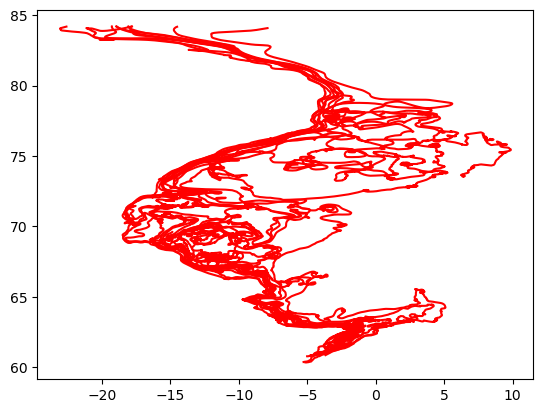

In [170]:
for i in tqdm.tqdm(np.arange(0, len(Iceland_overflows['traj_line'].trajectory), 5_000)):
    plt.plot(Iceland_overflows['traj_line'].lon.isel(trajectory=i), Iceland_overflows['traj_line'].lat.isel(trajectory=i), color='red')
    #plt.plot(EIC_overflows['traj_line'].lon.isel(trajectory=i), EIC_overflows['traj_line'].lat.isel(trajectory=i), color='red')
    #plt.plot(N_overflows['traj_line'].lon.isel(trajectory=i), N_overflows['traj_line'].lat.isel(trajectory=i), color='green')
plt.show()

100%|██████████| 13/13 [00:08<00:00,  1.47it/s]


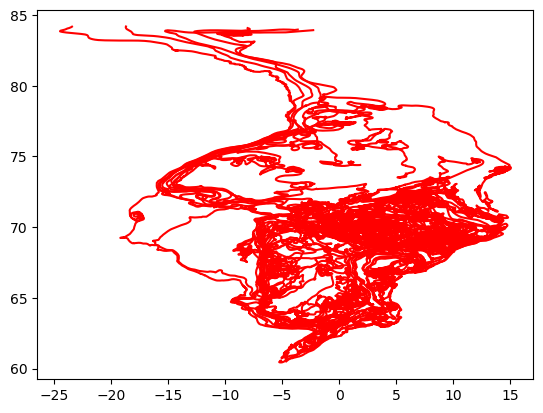

In [171]:
for i in tqdm.tqdm(np.arange(0, len(Norwegian_overflows['traj_line'].trajectory), 5_000)):
    plt.plot(Norwegian_overflows['traj_line'].lon.isel(trajectory=i), Norwegian_overflows['traj_line'].lat.isel(trajectory=i), color='red')
    #plt.plot(EIC_overflows['traj_line'].lon.isel(trajectory=i), EIC_overflows['traj_line'].lat.isel(trajectory=i), color='red')
    #plt.plot(N_overflows['traj_line'].lon.isel(trajectory=i), N_overflows['traj_line'].lat.isel(trajectory=i), color='green')
plt.show()

100%|██████████| 64/64 [00:46<00:00,  1.37it/s]


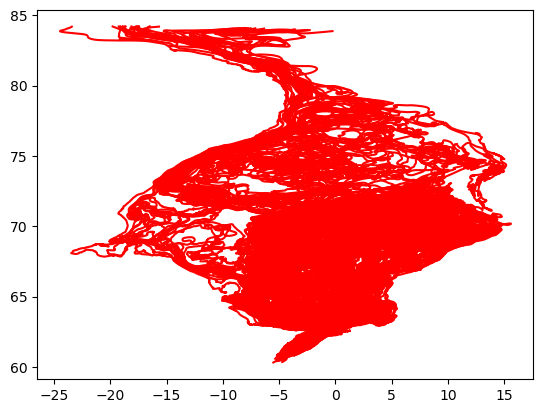

In [217]:
for i in tqdm.tqdm(np.arange(0, len(Norwegian_overflows['traj_line'].trajectory), 1_000)):
    plt.plot(Norwegian_overflows['traj_line'].lon.isel(trajectory=i), Norwegian_overflows['traj_line'].lat.isel(trajectory=i), color='red')
    #plt.plot(EIC_overflows['traj_line'].lon.isel(trajectory=i), EIC_overflows['traj_line'].lat.isel(trajectory=i), color='red')
    #plt.plot(N_overflows['traj_line'].lon.isel(trajectory=i), N_overflows['traj_line'].lat.isel(trajectory=i), color='green')
plt.show()

100%|██████████| 58/58 [00:44<00:00,  1.30it/s]


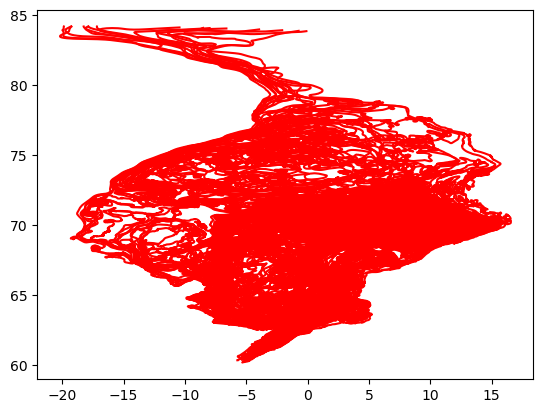

In [218]:
for i in tqdm.tqdm(np.arange(0, len(Lofoten_overflows['traj_line'].trajectory), 1_000)):
    plt.plot(Lofoten_overflows['traj_line'].lon.isel(trajectory=i), Lofoten_overflows['traj_line'].lat.isel(trajectory=i), color='red')
    #plt.plot(EIC_overflows['traj_line'].lon.isel(trajectory=i), EIC_overflows['traj_line'].lat.isel(trajectory=i), color='red')
    #plt.plot(N_overflows['traj_line'].lon.isel(trajectory=i), N_overflows['traj_line'].lat.isel(trajectory=i), color='green')
plt.show()

100%|██████████| 59/59 [00:42<00:00,  1.39it/s]


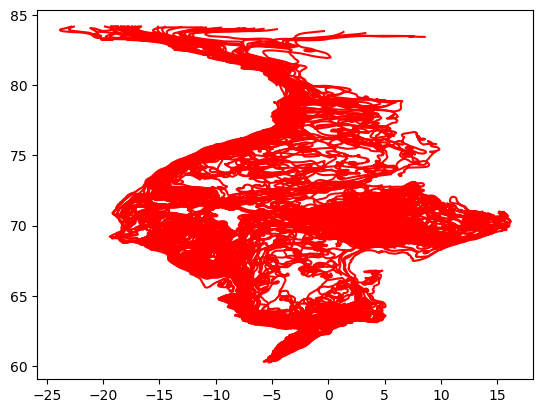

In [227]:
for i in tqdm.tqdm(np.arange(0, len(Iceland_overflows['traj_line'].trajectory), 1_000)):
    plt.plot(Iceland_overflows['traj_line'].lon.isel(trajectory=i), Iceland_overflows['traj_line'].lat.isel(trajectory=i), color='red')
    #plt.plot(EIC_overflows['traj_line'].lon.isel(trajectory=i), EIC_overflows['traj_line'].lat.isel(trajectory=i), color='red')
    #plt.plot(N_overflows['traj_line'].lon.isel(trajectory=i), N_overflows['traj_line'].lat.isel(trajectory=i), color='green')
plt.show()

In [228]:
#set(Lofoten_overflows['traj_line'])

In [224]:
Lofoten_overflows['traj_line']

<xarray.Dataset>
Dimensions:     (trajectory: 57947, obs: 20075)
Coordinates:
  * obs         (obs) int32 0 1 2 3 4 5 ... 20069 20070 20071 20072 20073 20074
  * trajectory  (trajectory) int64 44 62 106 137 ... 3518626 3518662 3518674
Data variables:
    age         (trajectory, obs) float32 dask.array<chunksize=(172, 20075), meta=np.ndarray>
    lat         (trajectory, obs) float64 dask.array<chunksize=(102, 15330), meta=np.ndarray>
    lon         (trajectory, obs) float64 dask.array<chunksize=(102, 15330), meta=np.ndarray>
    salt        (trajectory, obs) float32 dask.array<chunksize=(172, 20075), meta=np.ndarray>
    temp        (trajectory, obs) float32 dask.array<chunksize=(172, 20075), meta=np.ndarray>
    time        (trajectory, obs) datetime64[ns] dask.array<chunksize=(102, 15330), meta=np.ndarray>
    uvel        (trajectory, obs) float32 dask.array<chunksize=(172, 20075), meta=np.ndarray>
    vvel        (trajectory, obs) float32 dask.array<chunksize=(172, 20075), meta=np.ndarray>
    z           (trajectory, obs) float64 dask.array<chunksize=(102, 15330), meta=np.ndarray>
    sigma0      (trajectory, obs) float64 dask.array<chunksize=(172, 20075), meta=np.ndarray>
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_kernels:        SampleParticleAdvectionRK4_3Dsamplingagevelocity_...
    parcels_mesh:           spherical
    parcels_version:        3.1.0

In [ ]:
def connectivity_function(
    zarr_path=None,
    stations_path=None,
    start=None,
    end=None,
    dist=None,
    **kwargs,
):
    # upload trajectory and station data
    particles = load_sigma_traj_ds(zarr_path).compute()
    particles = particles.where(~particles.isnull().all("obs"), drop=True)
    stations = pd.read_excel(stations_path)

    # Filter observations for start and end experiment time (in observation_slice of drift)
    particles = particles.isel(obs=slice(start, end))

    # Mean radius of the Earth in km
    R = 6371  

    # Stations (targets)
    target_lon_deg = stations.set_index("tag").to_xarray().lon
    target_lat_deg = stations.set_index("tag").to_xarray().lat
    target_lon_km = R * np.cos(np.radians(target_lat_deg)) * np.radians(target_lon_deg)
    target_lat_km = R * np.radians(target_lat_deg)

    # Particles
    obs_lon_deg = particles.lon
    obs_lat_deg = particles.lat
    obs_lon_km = R * np.cos(np.radians(obs_lat_deg)) * np.radians(obs_lon_deg)
    obs_lat_km = R * np.radians(obs_lat_deg)

    # Calculate distance to target
    distance_to_target = (
        ((obs_lon_km - target_lon_km) ** 2) + ((obs_lat_km - target_lat_km) ** 2)
    ) ** 0.5

    # Return number of particles within a certain distance from target
    return (distance_to_target <= dist).sum(dim=["obs", "trajectory"]).compute()

In [44]:
EIC_overflow_heat_map_NOT_LINE = compute_heat_maps(EIC_overflows['traj_not_line'])

In [50]:
N_overflow_heat_map_NOT_LINE = compute_heat_maps(N_overflows['traj_not_line'])

In [54]:
#(EIC_overflow_heat_map_NOT_LINE['heat_map_probability']/EIC_overflow_heat_map['heat_map_probability']).plot();

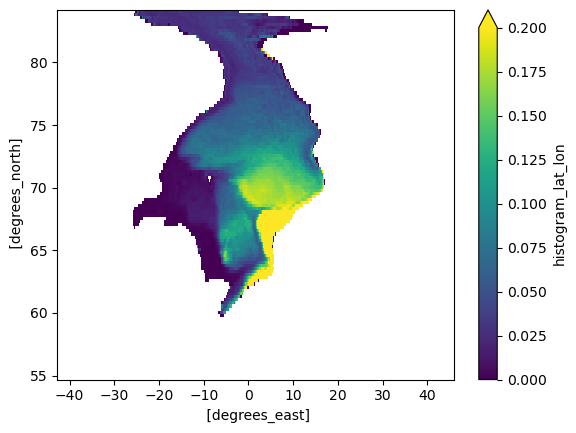

In [53]:
(N_overflow_heat_map_NOT_LINE['heat_map_probability']/heat_map_overflows*100).plot(vmin=0,vmax=.2);


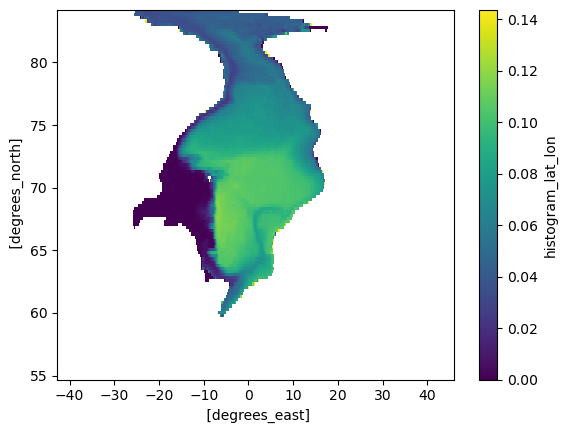

In [49]:
(EIC_overflow_heat_map_NOT_LINE['heat_map_probability']/heat_map_overflows*100).plot();

In [46]:
# plt.contour(mesh_mask.nav_lon, mesh_mask.nav_lat, mesh_mask.tmask.isel(t=0,z=0),levels=0,colors='k')
# np.log10(EIC_overflow_heat_map_NOT_LINE['heat_map_probability']).plot(cmap='YlOrRd')
# plt.show()

# plt.contour(mesh_mask.nav_lon, mesh_mask.nav_lat, mesh_mask.tmask.isel(t=0,z=0),levels=0,colors='k')
# np.log10(EIC_overflow_heat_map['heat_map_probability']).plot(cmap='YlOrRd')
# plt.show()

In [55]:
EIC_overflow_heat_map = compute_heat_maps(EIC_overflows['traj_line'])

In [56]:
N_overflow_heat_map = compute_heat_maps(N_overflows['traj_line'])

In [57]:
Svinoy_overflow_heat_map = compute_heat_maps(Svinoy_overflows['traj_line'])

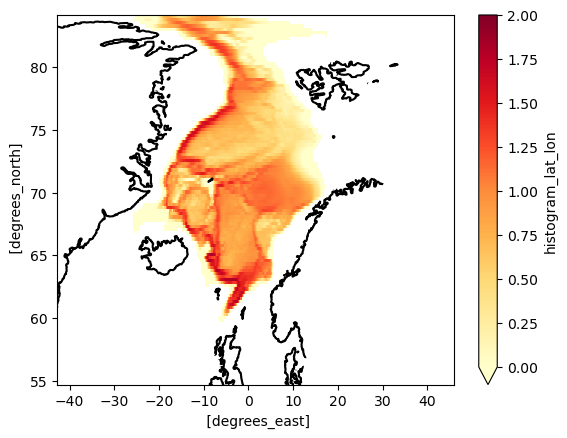

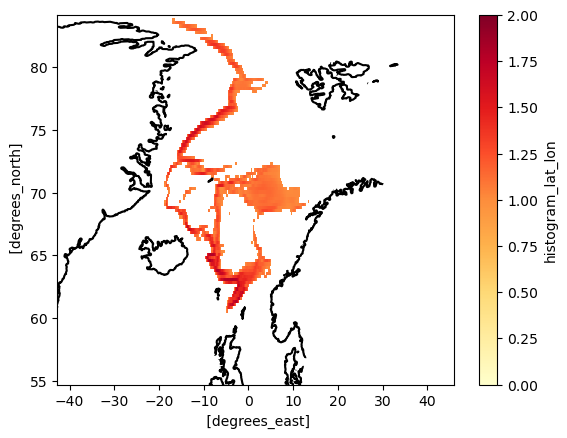

In [145]:
plt.contour(mesh_mask.nav_lon, mesh_mask.nav_lat, mesh_mask.tmask.isel(t=0,z=0),levels=0,colors='k')
np.log10(N_overflow_heat_map['heat_map_probability']).plot(cmap='YlOrRd',vmin=0,vmax=2)
plt.show()

plt.contour(mesh_mask.nav_lon, mesh_mask.nav_lat, mesh_mask.tmask.isel(t=0,z=0),levels=0,colors='k')
np.log10(N_overflow_heat_map['heat_map_probability']).where(np.log10(N_overflow_heat_map['heat_map_probability']) > 1).plot(cmap='YlOrRd',vmin=0,vmax=2)
plt.show()

In [120]:
# x = np.log10(EIC_overflow_heat_map['heat_map_probability'])

# x.where(x>1).plot(cmap='YlOrRd',vmin=0,vmax=2)

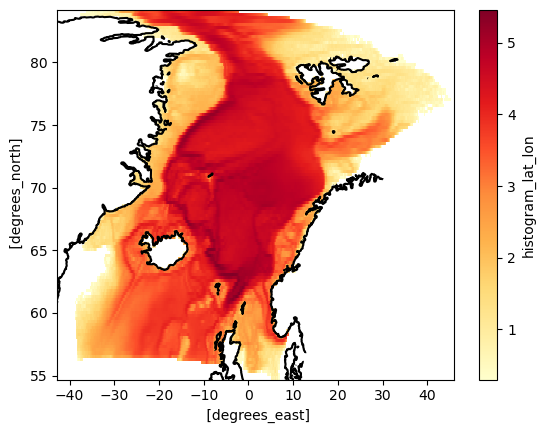

In [63]:
plt.contour(mesh_mask.nav_lon, mesh_mask.nav_lat, mesh_mask.tmask.isel(t=0,z=0),levels=0,colors='k')
np.log10(heat_map_all).where(np.log10(heat_map_all) > 0).plot(cmap='YlOrRd')
plt.show()


# np.log10(heat_map_all).where(np.log10(heat_map_all) > 4.5).plot(cmap='YlOrRd')
# plt.show()

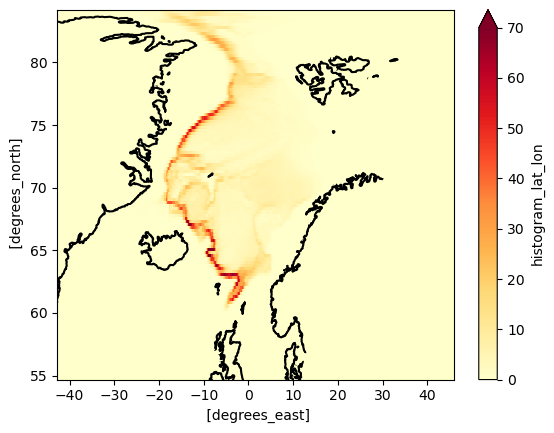

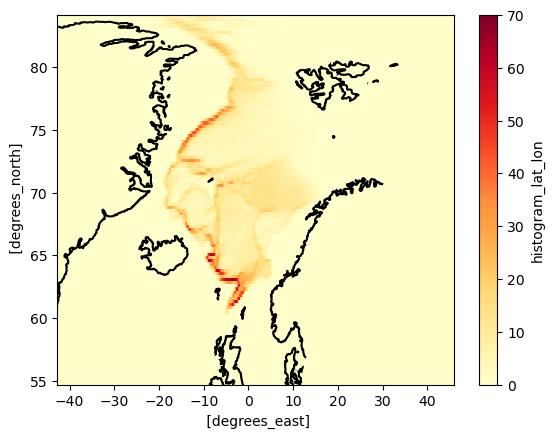

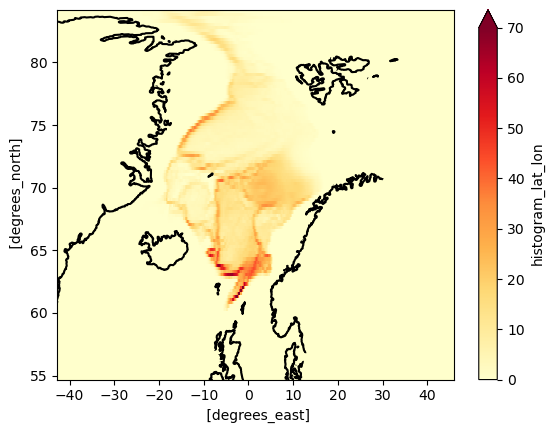

In [226]:
plt.contour(mesh_mask.nav_lon, mesh_mask.nav_lat, mesh_mask.tmask.isel(t=0,z=0),levels=0,colors='k')
EIC_overflow_heat_map['heat_map_probability'].plot(cmap='YlOrRd',vmin=0,vmax=70)
plt.show() 


plt.contour(mesh_mask.nav_lon, mesh_mask.nav_lat, mesh_mask.tmask.isel(t=0,z=0),levels=0,colors='k')
N_overflow_heat_map['heat_map_probability'].plot(cmap='YlOrRd',vmin=0,vmax=70)
plt.show() 

plt.contour(mesh_mask.nav_lon, mesh_mask.nav_lat, mesh_mask.tmask.isel(t=0,z=0),levels=0,colors='k')
Svinoy_overflow_heat_map['heat_map_probability'].plot(cmap='YlOrRd',vmin=0,vmax=70)
plt.show() 

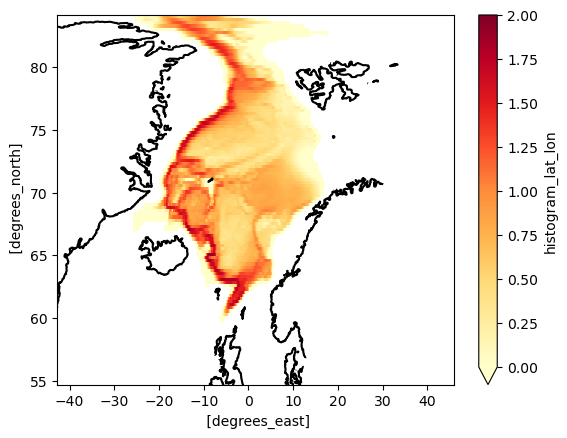

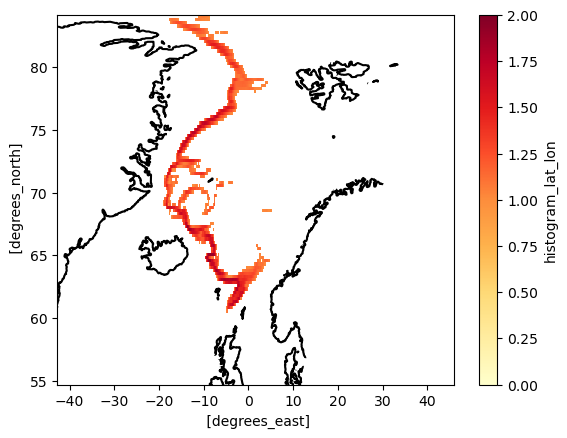

In [60]:
plt.contour(mesh_mask.nav_lon, mesh_mask.nav_lat, mesh_mask.tmask.isel(t=0,z=0),levels=0,colors='k')
np.log10(EIC_overflow_heat_map['heat_map_probability']).plot(cmap='YlOrRd',vmin=0,vmax=2)
plt.show() 


plt.contour(mesh_mask.nav_lon, mesh_mask.nav_lat, mesh_mask.tmask.isel(t=0,z=0),levels=0,colors='k')
np.log10(EIC_overflow_heat_map['heat_map_probability']).where(np.log10(EIC_overflow_heat_map['heat_map_probability']) > 1).plot(cmap='YlOrRd',vmin=0,vmax=2)
plt.show()


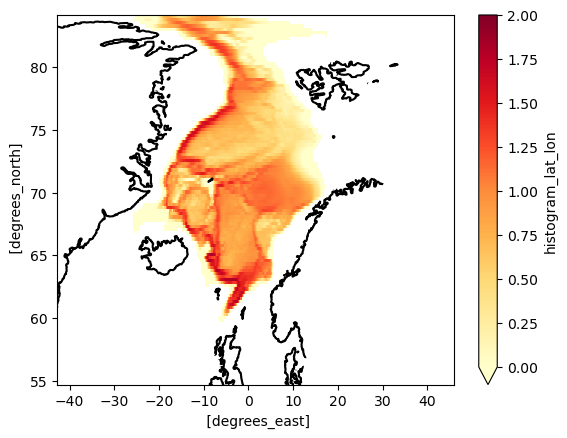

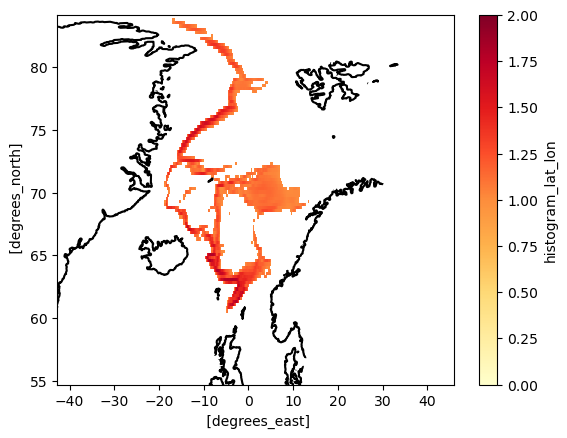

In [62]:
plt.contour(mesh_mask.nav_lon, mesh_mask.nav_lat, mesh_mask.tmask.isel(t=0,z=0),levels=0,colors='k')
np.log10(N_overflow_heat_map['heat_map_probability']).plot(cmap='YlOrRd',vmin=0,vmax=2)
plt.show()

plt.contour(mesh_mask.nav_lon, mesh_mask.nav_lat, mesh_mask.tmask.isel(t=0,z=0),levels=0,colors='k')
np.log10(N_overflow_heat_map['heat_map_probability']).where(np.log10(N_overflow_heat_map['heat_map_probability']) > 1).plot(cmap='YlOrRd',vmin=0,vmax=2)
plt.show()


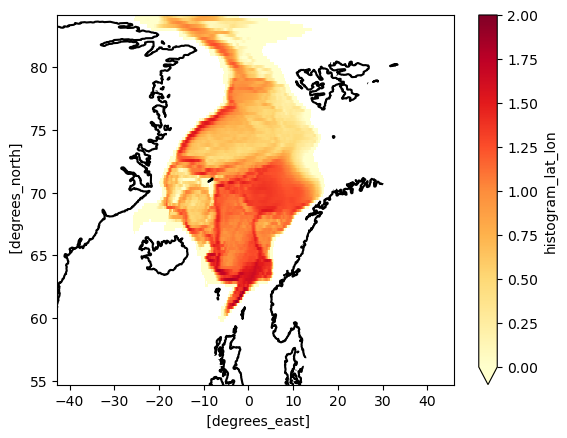

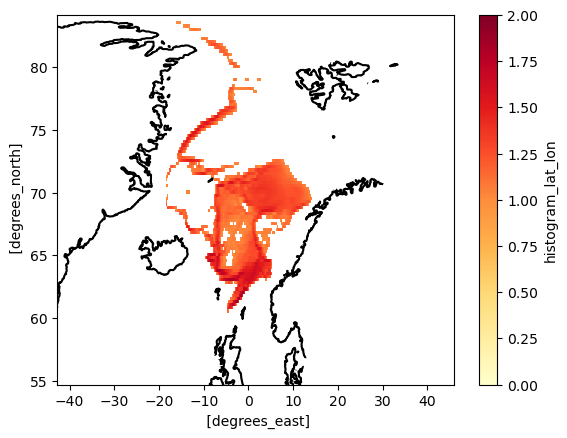

In [61]:
plt.contour(mesh_mask.nav_lon, mesh_mask.nav_lat, mesh_mask.tmask.isel(t=0,z=0),levels=0,colors='k')
np.log10(Svinoy_overflow_heat_map['heat_map_probability']).plot(cmap='YlOrRd',vmin=0,vmax=2)
plt.show()

plt.contour(mesh_mask.nav_lon, mesh_mask.nav_lat, mesh_mask.tmask.isel(t=0,z=0),levels=0,colors='k')
np.log10(Svinoy_overflow_heat_map['heat_map_probability']).where(np.log10(Svinoy_overflow_heat_map['heat_map_probability']) > 1).plot(cmap='YlOrRd',vmin=0,vmax=2)
plt.show()


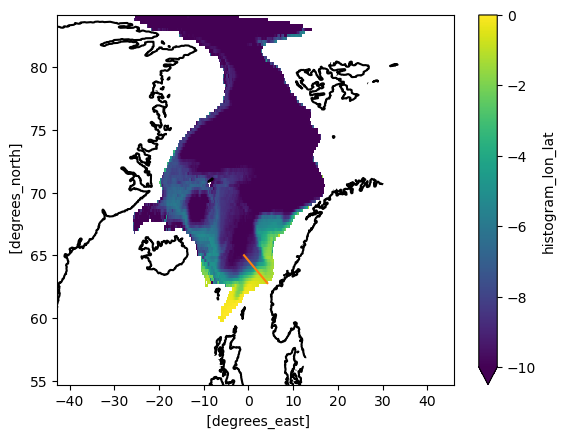

In [64]:
plt.contour(mesh_mask.nav_lon, mesh_mask.nav_lat, mesh_mask.tmask.isel(t=0,z=0),levels=0,colors='k')
heatmap = (Svinoy_mean_age_overflows.T*hours_to_years).plot(cmap='viridis', vmin=-10,vmax=0)
plt.plot([4.21, -1], [62.78, 65.], color='tab:orange', label='Svinoy section')
cbar = heatmap.colorbar
#cbar.set_ticks(np.arange(0, 100 + 10, 10))
#cbar.ax.yaxis.set_major_formatter(ticker.PercentFormatter())
plt.show()

In [66]:
#@heat_map_svinoy_overflows.plot()

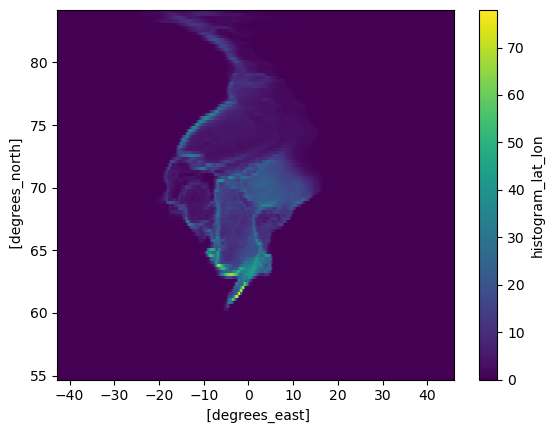

In [70]:
Svinoy_overflow_heat_map['heat_map_probability'].plot()

In [74]:
#((Svinoy_overflow_heat_map['heat_map_probability']/heat_map_overflows)*100).plot()

In [68]:
heat_map_svinoy_overflows = compute_probability(Svinoy_overflows['traj_line'])
heat_map_EIC_overflows = compute_probability(EIC_overflows['traj_line'])
heat_map_N_overflows = compute_probability(N_overflows['traj_line'])


In [18]:
# lon_rechunk = rechunk_for_hist(ds['lon'])
# lat_rechunk = rechunk_for_hist(ds['lat'])

def rechunk_lat_lon(ds):
    """
    Rechunk latitude and longitude data from the given xarray dataset.

    Parameters:
    ds (xarray.Dataset): The input dataset containing 'lon' and 'lat' variables.

    Returns:
    tuple: A tuple containing the rechunked longitude and latitude arrays.
    """
    lon_rechunk = rechunk_for_hist(ds['lon'])
    lat_rechunk = rechunk_for_hist(ds['lat'])
    
    return lon_rechunk, lat_rechunk

In [146]:
lon, lat = heat_map_all.lon,heat_map_all.lat
def plot_particle_maps(ds_binned, cmap, cbar_label, title, ticks,
                       vmin=None, vmax=None):
    fig = plt.figure(figsize=(8, 5))
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.Orthographic(central_longitude=-10, central_latitude=77))

    ax.set_extent([-40, 20, 55, 85], crs=ccrs.PlateCarree())
    # Plot the bathymetry data on the orthographic map
    pcolormesh = ax.pcolormesh(
        mesh_mask.nav_lon, mesh_mask.nav_lat, land_mask, 
        transform=ccrs.PlateCarree(), cmap='binary')
    
    # Determine vmin and vmax if not provided
    if vmin is None:
        vmin = np.min(ds_binned)
    if vmax is None:
        vmax = np.max(ds_binned)

    # Plot the particle density
    x = ax.pcolormesh(lon, lat, ds_binned, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
    cbar = plt.colorbar(x)
    cbar.set_label(cbar_label)
    cbar.set_ticks(ticks)
    ax.coastlines()
    gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xlocator = plt.FixedLocator(np.arange(-180, 181, 10))  # Set x-axis grid line intervals
    gl.ylocator = plt.FixedLocator(np.arange(-90, 91, 10))    # Set y-axis grid line intervals
    gl.xlabel_style = {'size': 10}
    gl.ylabel_style = {'size': 10}
    ax.plot([5.5, -1], [62.24, 65.], color='tab:pink', label='Svinoy section', transform=ccrs.PlateCarree())
    ax.plot([-6.43, -6.43], [62.15, 64.5], color='tab:green', label='N section', transform=ccrs.PlateCarree())
    ax.plot([-15, -11.95], [66.25, 68.7], color='blue', label='LN section', transform=ccrs.PlateCarree())
    ax.plot([-6.5, -2.5], [61.3, 60.3], color='k', transform=ccrs.PlateCarree())
    ax.set_title(title)
    plt.show()

In [147]:
lon_rechunk, lat_rechunk = rechunk_lat_lon(ds_overflows)[0], rechunk_lat_lon(ds_overflows)[1]

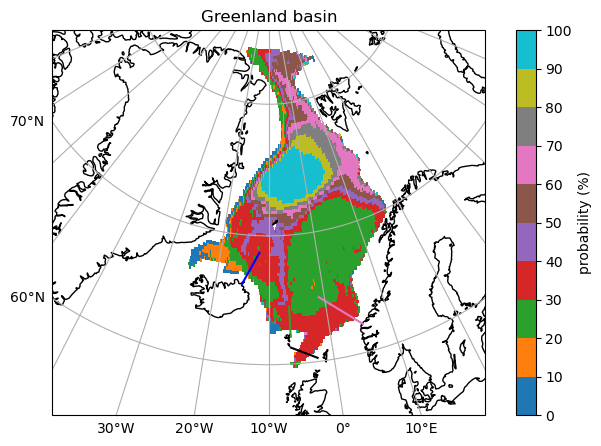

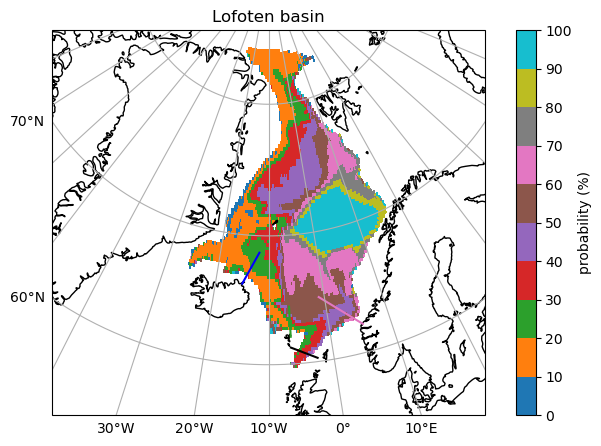

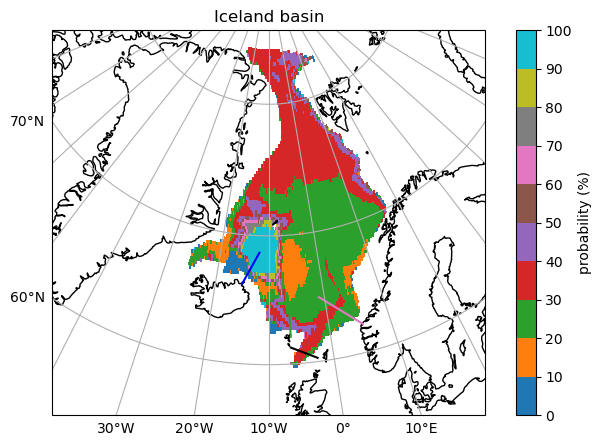

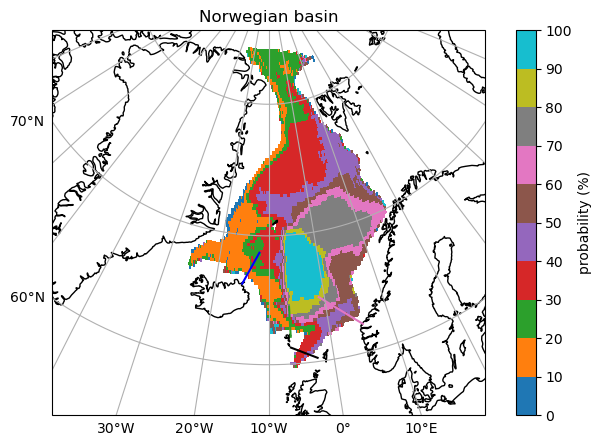

In [151]:
plot_particle_maps((heat_map_greenland_overflows / heat_map_overflows) * 100, 'tab10',
                   'probability (%)', 'Greenland basin', np.arange(0, 100 + 10, 10),vmin=0, vmax=100)

plot_particle_maps((heat_map_lofoten_overflows / heat_map_overflows) * 100, 'tab10',
                   'probability (%)', 'Lofoten basin', np.arange(0, 100 + 10, 10),vmin=0, vmax=100)

plot_particle_maps((heat_map_iceland_overflows / heat_map_overflows) * 100, 'tab10',
                   'probability (%)', 'Iceland basin', np.arange(0, 100 + 10, 10),vmin=0, vmax=100)

plot_particle_maps((heat_map_norwegian_overflows / heat_map_overflows) * 100, 'tab10',
                   'probability (%)', 'Norwegian basin', np.arange(0, 100 + 10, 10),vmin=0, vmax=100)

In [152]:
overflow_prob = 100*(heat_map_overflows/ds_overflows.trajectory.size)

In [57]:
# overflow_prob.plot(cmap='hot_r',vmin=0,vmax=60)
# plt.show()

# (overflow_prob.where(overflow_prob > 10)).plot(cmap='hot_r',vmin=0,vmax=60)
# plt.show()

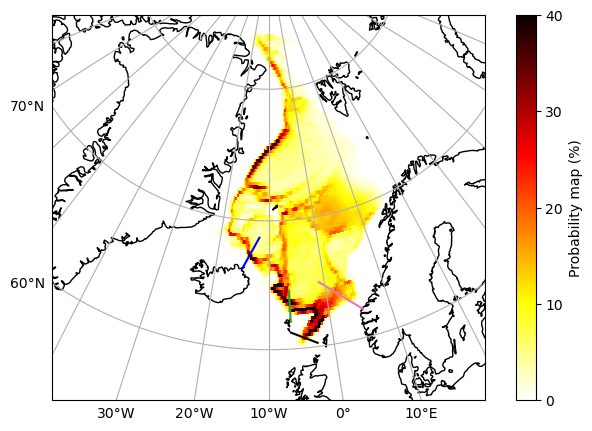

In [153]:
plot_particle_maps(overflow_prob.where(overflow_prob > 0), 'hot_r', 'Probability map (%)', '', np.arange(0, 41, 10),vmin=0,vmax=40)

In [154]:
#plot_particle_maps(probs.where(probs > 0), 'hot_r', 'Probability map (%)', '', np.arange(0, 51, 10),vmin=0,vmax=50)

In [156]:
#plot_particle_maps(probs.where(probs > 0), 'hot_r', 'Probability map (%)', '', np.arange(0, 41, 10),vmin=0,vmax=50)

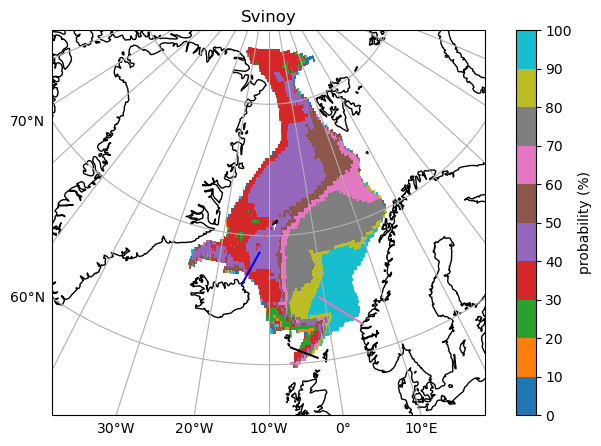

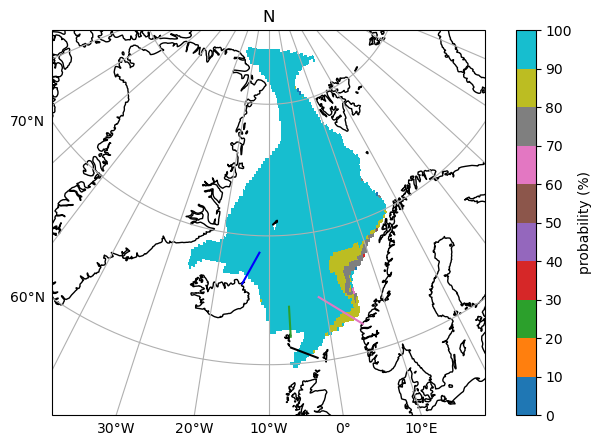

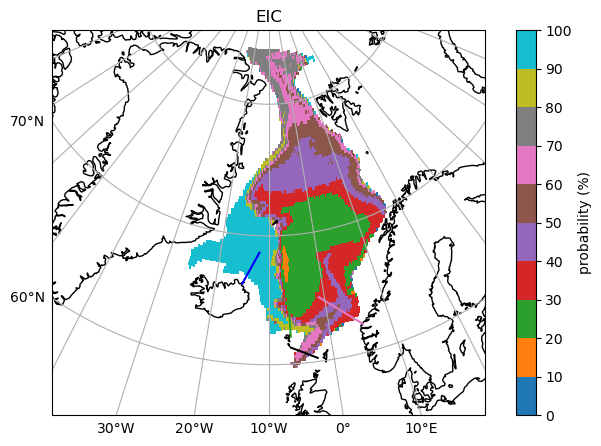

In [78]:
plot_particle_maps((heat_map_svinoy_overflows / heat_map_overflows) * 100, 'tab10',
                   'probability (%)', 'Svinoy', np.arange(0, 100 + 10, 10),vmin=0, vmax=100)

plot_particle_maps((heat_map_N_overflows / heat_map_overflows) * 100, 'tab10',
                   'probability (%)', 'N', np.arange(0, 100 + 10, 10),vmin=0, vmax=100)

plot_particle_maps((heat_map_EIC_overflows / heat_map_overflows) * 100, 'tab10',
                     'probability (%)', 'EIC', np.arange(0, 100 + 10, 10),vmin=0, vmax=100)

# probability for a particle to cross that section over any time. 

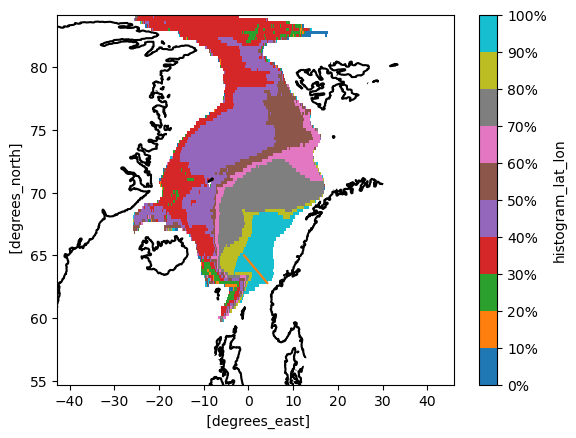

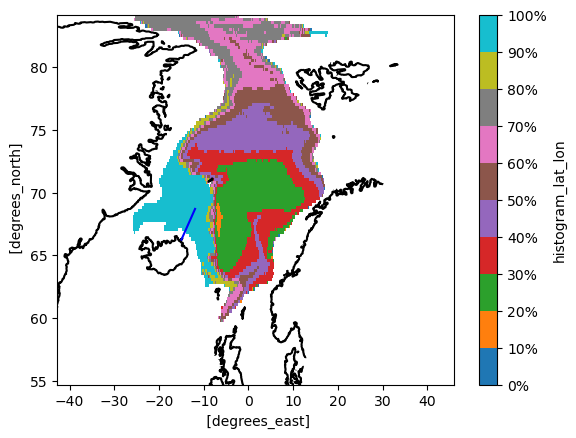

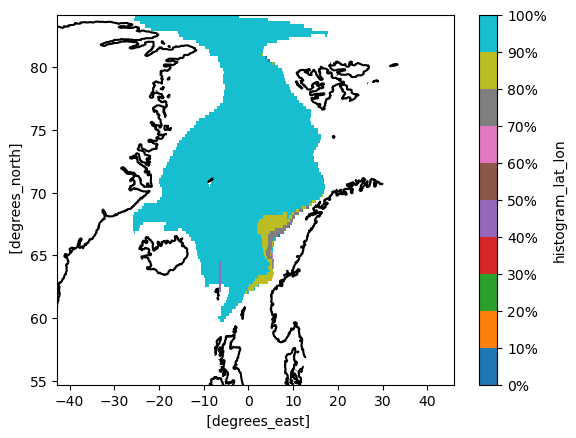

In [80]:
import matplotlib.ticker as ticker

plt.contour(mesh_mask.nav_lon, mesh_mask.nav_lat, mesh_mask.tmask.isel(t=0,z=0),levels=0,colors='k')
heatmap = ((heat_map_svinoy_overflows / heat_map_overflows) * 100).plot(cmap='tab10')
plt.plot([4.21, -1], [62.78, 65.], color='tab:orange', label='Svinoy section')
# Adjust colorbar ticks
cbar = heatmap.colorbar
cbar.set_ticks(np.arange(0,100+10,10))
cbar.ax.yaxis.set_major_formatter(ticker.PercentFormatter())
plt.show()

plt.contour(mesh_mask.nav_lon, mesh_mask.nav_lat, mesh_mask.tmask.isel(t=0,z=0),levels=0,colors='k')
heatmap = ((heat_map_EIC_overflows / heat_map_overflows) * 100).plot(cmap='tab10')
plt.plot([-15, -11.95], [66.25, 68.7], color='blue', label='EIC section')
# Adjust colorbar ticks
cbar = heatmap.colorbar
cbar.set_ticks(np.arange(0,100+10,10))
cbar.ax.yaxis.set_major_formatter(ticker.PercentFormatter())
plt.show()

plt.contour(mesh_mask.nav_lon, mesh_mask.nav_lat, mesh_mask.tmask.isel(t=0,z=0),levels=0,colors='k')
heatmap = ((heat_map_N_overflows / heat_map_overflows) * 100).plot(cmap='tab10')
plt.plot([-6.43, -6.43], [62.15, 64.5], color='tab:purple', label='N section')
cbar = heatmap.colorbar
cbar.set_ticks(np.arange(0,100+10,10))
cbar.ax.yaxis.set_major_formatter(ticker.PercentFormatter())
plt.show()

In [278]:


# plt.contour(xr.where(((heat_map_svinoy_overflows / heat_map_overflows) * 100).where(lambda x: x > 50) > 0,1,0),levels=0,colors='k')
# plt.contour(xr.where(((heat_map_EIC_overflows / heat_map_overflows) * 100).where(lambda x: x > 90) > 0,1,0),levels=0,colors='blue')
# #plt.contour(xr.where(((heat_map_N_overflows / heat_map_overflows) * 100).where(lambda x: x > 90) > 0,1,0),levels=0,colors='red')

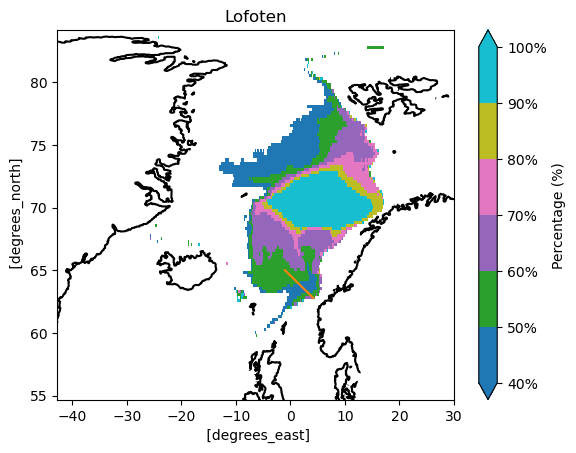

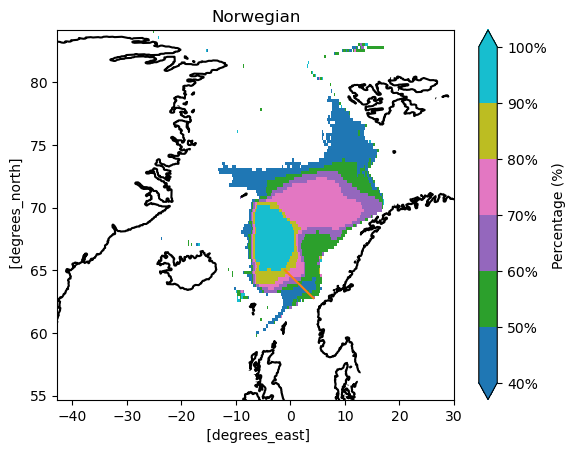

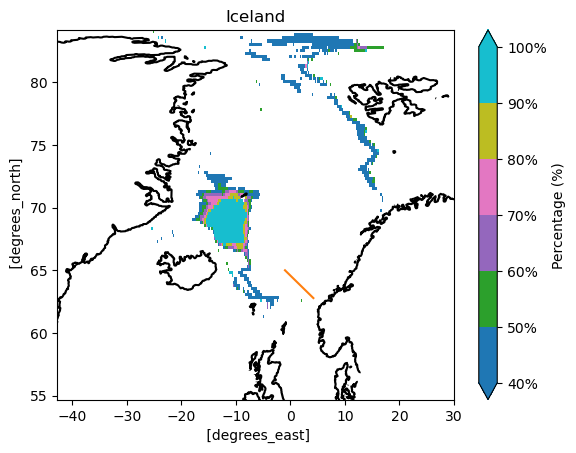

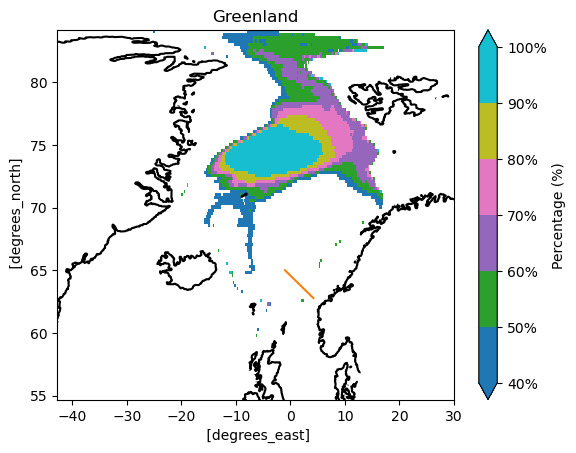

In [30]:
# Assuming heat_map_lofoten_overflows and heat_map_overflows are defined
heatmap = ((heat_map_lofoten_overflows / heat_map_overflows) * 100).where(lambda x: x > 40)
# Define levels for the contour and the color map
levels = np.arange(40, 101, 10)  # Levels from 40% to 100%
cmap = plt.get_cmap('tab10', len(levels) - 1)  # Create a colormap with the number of levels
# Create the contour plot
plt.contour(mesh_mask.nav_lon, mesh_mask.nav_lat, mesh_mask.tmask.isel(t=0, z=0), levels=0, colors='k',extend='both')
# Create the heatmap plot
plot = heatmap.plot(cmap=cmap, levels=levels, extend='both')
# Plot the Svinoy section line
plt.plot([4.21, -1], [62.78, 65.], color='tab:orange', label='Svinoy section')
cbar = plot.colorbar
cbar.set_ticks(levels)  # Set ticks to match the defined levels
cbar.ax.yaxis.set_major_formatter(ticker.PercentFormatter())  # Format as percentage
# Set the colorbar label
plt.xlim(None,30)
cbar.set_label('Percentage (%)')
plt.title('Lofoten')
plt.show()

# Assuming heat_map_lofoten_overflows and heat_map_overflows are defined
heatmap = ((heat_map_norwegian_overflows / heat_map_overflows) * 100).where(lambda x: x > 40)
# Define levels for the contour and the color map
levels = np.arange(40, 101, 10)  # Levels from 40% to 100%
cmap = plt.get_cmap('tab10', len(levels) - 1)  # Create a colormap with the number of levels
# Create the contour plot
plt.contour(mesh_mask.nav_lon, mesh_mask.nav_lat, mesh_mask.tmask.isel(t=0, z=0), levels=0, colors='k',extend='both')
# Create the heatmap plot
plot = heatmap.plot(cmap=cmap, levels=levels, extend='both')
# Plot the Svinoy section line
plt.plot([4.21, -1], [62.78, 65.], color='tab:orange', label='Svinoy section')
cbar = plot.colorbar
cbar.set_ticks(levels)  # Set ticks to match the defined levels
cbar.ax.yaxis.set_major_formatter(ticker.PercentFormatter())  # Format as percentage
# Set the colorbar label
plt.xlim(None,30)
cbar.set_label('Percentage (%)')
plt.title('Norwegian')
plt.show()

# Assuming heat_map_lofoten_overflows and heat_map_overflows are defined
heatmap = ((heat_map_iceland_overflows / heat_map_overflows) * 100).where(lambda x: x > 40)
# Define levels for the contour and the color map
levels = np.arange(40, 101, 10)  # Levels from 40% to 100%
cmap = plt.get_cmap('tab10', len(levels) - 1)  # Create a colormap with the number of levels
# Create the contour plot
plt.contour(mesh_mask.nav_lon, mesh_mask.nav_lat, mesh_mask.tmask.isel(t=0, z=0), levels=0, colors='k',extend='both')
# Create the heatmap plot
plot = heatmap.plot(cmap=cmap, levels=levels, extend='both')
# Plot the Svinoy section line
plt.plot([4.21, -1], [62.78, 65.], color='tab:orange', label='Svinoy section')
cbar = plot.colorbar
cbar.set_ticks(levels)  # Set ticks to match the defined levels
cbar.ax.yaxis.set_major_formatter(ticker.PercentFormatter())  # Format as percentage
# Set the colorbar label
plt.xlim(None,30)
cbar.set_label('Percentage (%)')
plt.title('Iceland')
plt.show()

# Assuming heat_map_lofoten_overflows and heat_map_overflows are defined
heatmap = ((heat_map_greenland_overflows / heat_map_overflows) * 100).where(lambda x: x > 40)
# Define levels for the contour and the color map
levels = np.arange(40, 101, 10)  # Levels from 40% to 100%
cmap = plt.get_cmap('tab10', len(levels) - 1)  # Create a colormap with the number of levels
# Create the contour plot
plt.contour(mesh_mask.nav_lon, mesh_mask.nav_lat, mesh_mask.tmask.isel(t=0, z=0), levels=0, colors='k',extend='both')
# Create the heatmap plot
plot = heatmap.plot(cmap=cmap, levels=levels, extend='both')
# Plot the Svinoy section line
plt.plot([4.21, -1], [62.78, 65.], color='tab:orange', label='Svinoy section')
cbar = plot.colorbar
cbar.set_ticks(levels)  # Set ticks to match the defined levels
cbar.ax.yaxis.set_major_formatter(ticker.PercentFormatter())  # Format as percentage
plt.xlim(None,30)
# Set the colorbar label
cbar.set_label('Percentage (%)')
plt.title('Greenland')
plt.show()


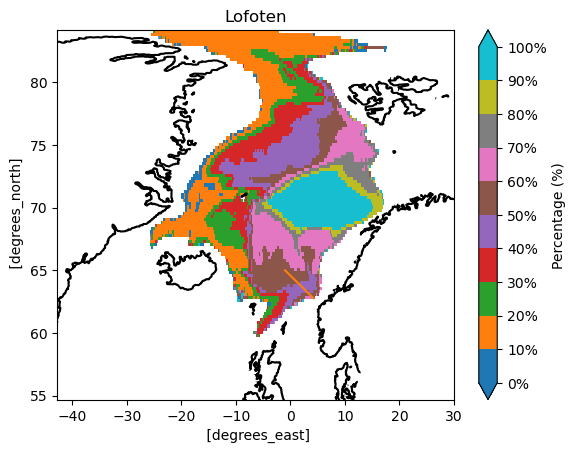

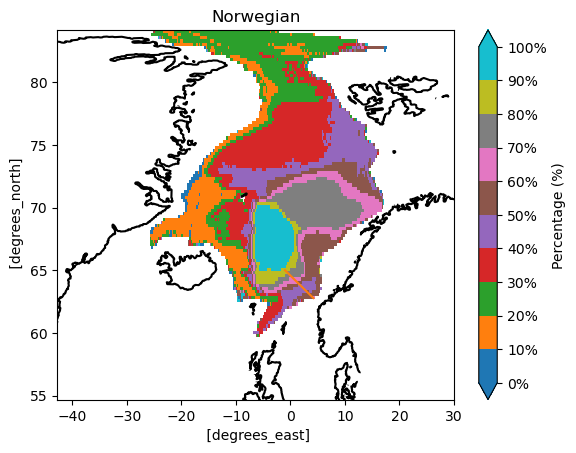

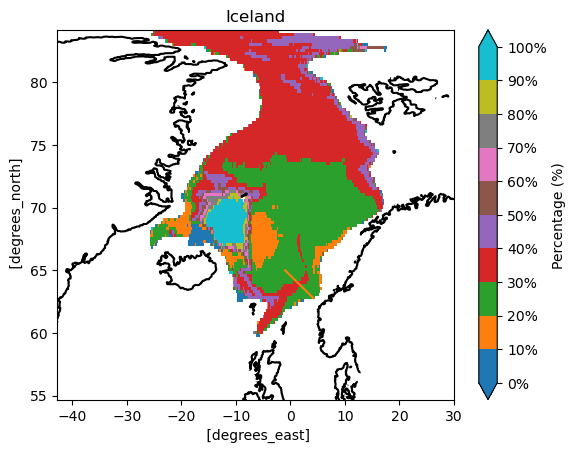

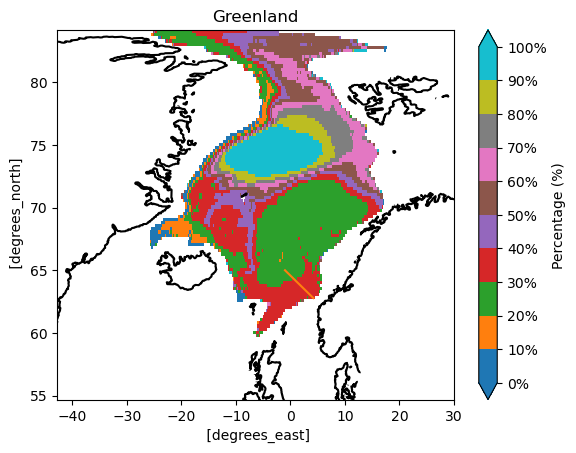

In [32]:
# Assuming heat_map_lofoten_overflows and heat_map_overflows are defined
heatmap = ((heat_map_lofoten_overflows / heat_map_overflows) * 100)
# Define levels for the contour and the color map
levels = np.arange(0, 101, 10)  # Levels from 40% to 100%
cmap = plt.get_cmap('tab10', len(levels) - 1)  # Create a colormap with the number of levels
# Create the contour plot
plt.contour(mesh_mask.nav_lon, mesh_mask.nav_lat, mesh_mask.tmask.isel(t=0, z=0), levels=0, colors='k',extend='both')
# Create the heatmap plot
plot = heatmap.plot(cmap=cmap, levels=levels, extend='both')
# Plot the Svinoy section line
plt.plot([4.21, -1], [62.78, 65.], color='tab:orange', label='Svinoy section')
cbar = plot.colorbar
cbar.set_ticks(levels)  # Set ticks to match the defined levels
cbar.ax.yaxis.set_major_formatter(ticker.PercentFormatter())  # Format as percentage
# Set the colorbar label
plt.xlim(None,30)
cbar.set_label('Percentage (%)')
plt.title('Lofoten')
plt.show()

# Assuming heat_map_lofoten_overflows and heat_map_overflows are defined
heatmap = ((heat_map_norwegian_overflows / heat_map_overflows) * 100)
# Define levels for the contour and the color map
levels = np.arange(0, 101, 10)  # Levels from 40% to 100%
cmap = plt.get_cmap('tab10', len(levels) - 1)  # Create a colormap with the number of levels
# Create the contour plot
plt.contour(mesh_mask.nav_lon, mesh_mask.nav_lat, mesh_mask.tmask.isel(t=0, z=0), levels=0, colors='k',extend='both')
# Create the heatmap plot
plot = heatmap.plot(cmap=cmap, levels=levels, extend='both')
# Plot the Svinoy section line
plt.plot([4.21, -1], [62.78, 65.], color='tab:orange', label='Svinoy section')
cbar = plot.colorbar
cbar.set_ticks(levels)  # Set ticks to match the defined levels
cbar.ax.yaxis.set_major_formatter(ticker.PercentFormatter())  # Format as percentage
# Set the colorbar label
plt.xlim(None,30)
cbar.set_label('Percentage (%)')
plt.title('Norwegian')
plt.show()

# Assuming heat_map_lofoten_overflows and heat_map_overflows are defined
heatmap = ((heat_map_iceland_overflows / heat_map_overflows) * 100)
# Define levels for the contour and the color map
levels = np.arange(0, 101, 10)  # Levels from 40% to 100%
cmap = plt.get_cmap('tab10', len(levels) - 1)  # Create a colormap with the number of levels
# Create the contour plot
plt.contour(mesh_mask.nav_lon, mesh_mask.nav_lat, mesh_mask.tmask.isel(t=0, z=0), levels=0, colors='k',extend='both')
# Create the heatmap plot
plot = heatmap.plot(cmap=cmap, levels=levels, extend='both')
# Plot the Svinoy section line
plt.plot([4.21, -1], [62.78, 65.], color='tab:orange', label='Svinoy section')
cbar = plot.colorbar
cbar.set_ticks(levels)  # Set ticks to match the defined levels
cbar.ax.yaxis.set_major_formatter(ticker.PercentFormatter())  # Format as percentage
# Set the colorbar label
plt.xlim(None,30)
cbar.set_label('Percentage (%)')
plt.title('Iceland')
plt.show()

# Assuming heat_map_lofoten_overflows and heat_map_overflows are defined
heatmap = ((heat_map_greenland_overflows / heat_map_overflows) * 100)
# Define levels for the contour and the color map
levels = np.arange(0, 101, 10)  # Levels from 40% to 100%
cmap = plt.get_cmap('tab10', len(levels) - 1)  # Create a colormap with the number of levels
# Create the contour plot
plt.contour(mesh_mask.nav_lon, mesh_mask.nav_lat, mesh_mask.tmask.isel(t=0, z=0), levels=0, colors='k',extend='both')
# Create the heatmap plot
plot = heatmap.plot(cmap=cmap, levels=levels, extend='both')
# Plot the Svinoy section line
plt.plot([4.21, -1], [62.78, 65.], color='tab:orange', label='Svinoy section')
cbar = plot.colorbar
cbar.set_ticks(levels)  # Set ticks to match the defined levels
cbar.ax.yaxis.set_major_formatter(ticker.PercentFormatter())  # Format as percentage
plt.xlim(None,30)
# Set the colorbar label
cbar.set_label('Percentage (%)')
plt.title('Greenland')
plt.show()


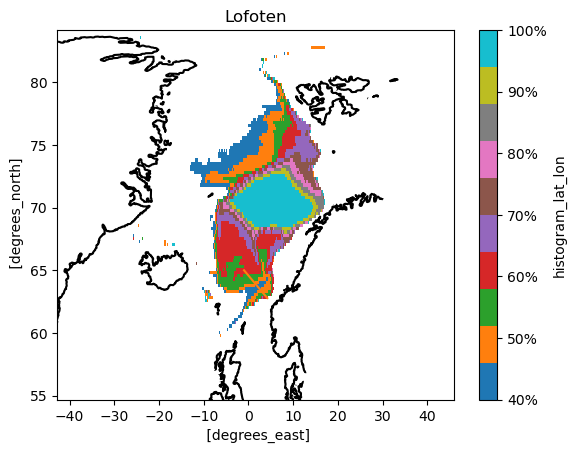

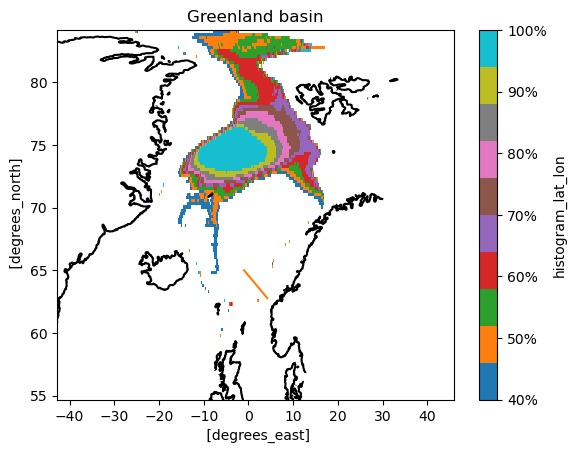

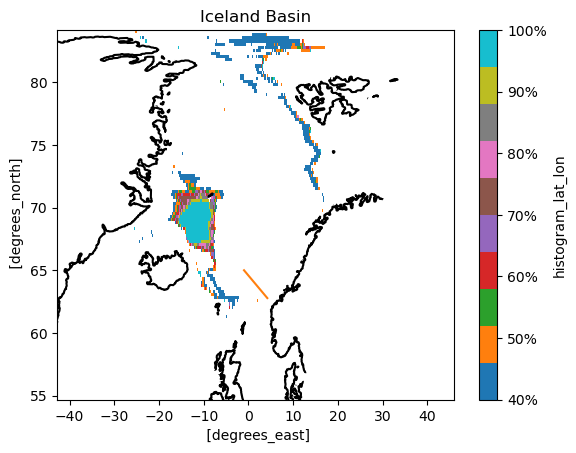

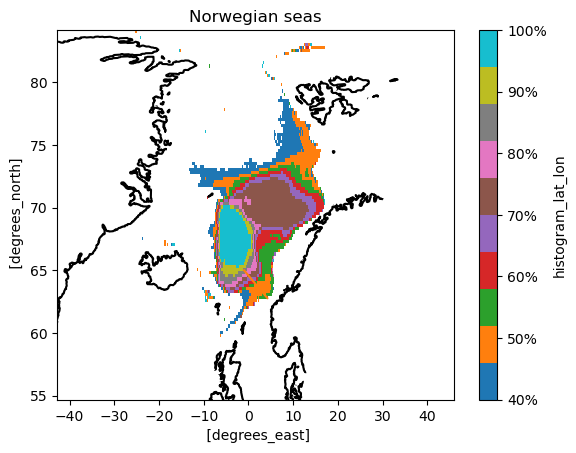

In [33]:
plt.contour(mesh_mask.nav_lon, mesh_mask.nav_lat, mesh_mask.tmask.isel(t=0,z=0),levels=0,colors='k')
heatmap = ((heat_map_lofoten_overflows / heat_map_overflows) * 100).where(lambda x: x > 40)
plot = heatmap.plot(cmap='tab10')
plt.plot([4.21, -1], [62.78, 65.], color='tab:orange', label='Svinoy section')
# Adjust colorbar ticks
cbar = plot.colorbar
cbar.set_ticks(np.arange(40,100+10,10))
cbar.ax.yaxis.set_major_formatter(ticker.PercentFormatter())
plt.title('Lofoten')
plt.show()


plt.contour(mesh_mask.nav_lon, mesh_mask.nav_lat, mesh_mask.tmask.isel(t=0,z=0),levels=0,colors='k')
heatmap = ((heat_map_greenland_overflows / heat_map_overflows) * 100).where(lambda x: x > 40)
plot = heatmap.plot(cmap='tab10')
plt.plot([4.21, -1], [62.78, 65.], color='tab:orange', label='Svinoy section')
# Adjust colorbar ticks
cbar = plot.colorbar
cbar.set_ticks(np.arange(40,100+10,10))
cbar.ax.yaxis.set_major_formatter(ticker.PercentFormatter())
plt.title('Greenland basin')
plt.show()

plt.contour(mesh_mask.nav_lon, mesh_mask.nav_lat, mesh_mask.tmask.isel(t=0,z=0),levels=0,colors='k')
heatmap = ((heat_map_iceland_overflows / heat_map_overflows) * 100).where(lambda x: x > 40)
plot = heatmap.plot(cmap='tab10')
plt.plot([4.21, -1], [62.78, 65.], color='tab:orange', label='Svinoy section')
# Adjust colorbar ticks
cbar = plot.colorbar
cbar.set_ticks(np.arange(40,100+10,10))
cbar.ax.yaxis.set_major_formatter(ticker.PercentFormatter())
plt.title('Iceland Basin')
plt.show()

plt.contour(mesh_mask.nav_lon, mesh_mask.nav_lat, mesh_mask.tmask.isel(t=0,z=0),levels=0,colors='k')
heatmap = ((heat_map_norwegian_overflows / heat_map_overflows) * 100).where(lambda x: x > 40)
plot = heatmap.plot(cmap='tab10')
plt.plot([4.21, -1], [62.78, 65.], color='tab:orange', label='Svinoy section')
# Adjust colorbar ticks
cbar = plot.colorbar
cbar.set_ticks(np.arange(40,100+10,10))
cbar.ax.yaxis.set_major_formatter(ticker.PercentFormatter())
plt.title('Norwegian seas')
plt.show()

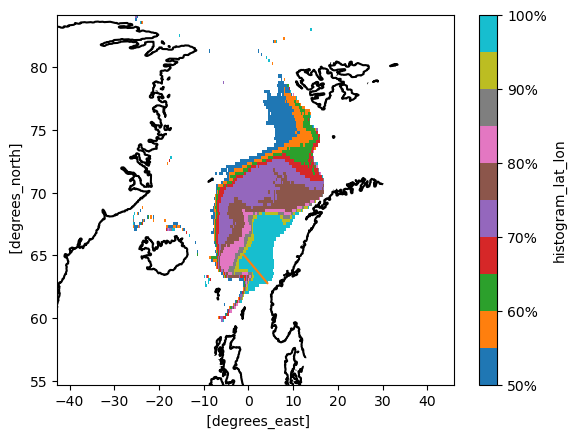

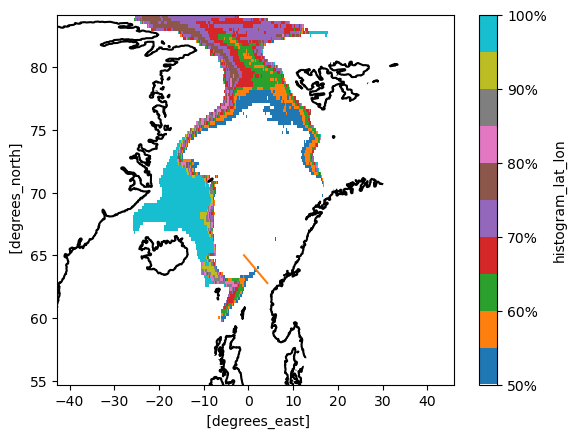

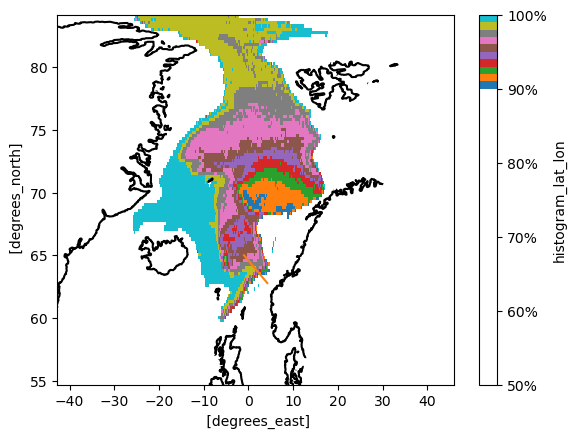

In [102]:
plt.contour(mesh_mask.nav_lon, mesh_mask.nav_lat, mesh_mask.tmask.isel(t=0,z=0),levels=0,colors='k')
heatmap = ((heat_map_svinoy_overflows / heat_map_overflows) * 100).where(lambda x: x > 50)
plot = heatmap.plot(cmap='tab10')
plt.plot([4.21, -1], [62.78, 65.], color='tab:orange', label='Svinoy section')
# Adjust colorbar ticks
cbar = plot.colorbar
cbar.set_ticks(np.arange(50,100+10,10))
cbar.ax.yaxis.set_major_formatter(ticker.PercentFormatter())
plt.show()

plt.contour(mesh_mask.nav_lon, mesh_mask.nav_lat, mesh_mask.tmask.isel(t=0,z=0),levels=0,colors='k')
heatmap = ((heat_map_EIC_overflows / heat_map_overflows) * 100).where(lambda x: x > 50)
plot = heatmap.plot(cmap='tab10')
plt.plot([4.21, -1], [62.78, 65.], color='tab:orange', label='Svinoy section')
# Adjust colorbar ticks
cbar = plot.colorbar
cbar.set_ticks(np.arange(50,100+10,10))
cbar.ax.yaxis.set_major_formatter(ticker.PercentFormatter())
plt.show()

plt.contour(mesh_mask.nav_lon, mesh_mask.nav_lat, mesh_mask.tmask.isel(t=0,z=0),levels=0,colors='k')
heatmap = ((heat_map_N_overflows / heat_map_overflows) * 100).where(lambda x: x > 90)
plot = heatmap.plot(cmap='tab10')
plt.plot([4.21, -1], [62.78, 65.], color='tab:orange', label='Svinoy section')
# Adjust colorbar ticks
cbar = plot.colorbar
cbar.set_ticks(np.arange(50,100+10,10))
cbar.ax.yaxis.set_major_formatter(ticker.PercentFormatter())
plt.show()


In [ ]:
# plot trajectories 

